In [1]:
from brian2 import *
from keras.datasets import mnist
from tqdm import tqdm
from sklearn import metrics
import numpy as np
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from spikingjelly import visualizing
import utils
from collections import defaultdict
import networkx as nx
from matplotlib.ticker import MultipleLocator
import os

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# simplified classification (0 1 and 8)
X_train = X_train[(y_train == 1) | (y_train == 0)]
y_train = y_train[(y_train == 1) | (y_train == 0)]
X_test = X_test[(y_test == 1) | (y_test == 0)]
y_test = y_test[(y_test == 1) | (y_test == 0)]

# pixel intensity to Hz (255 becoms ~63Hz)
X_train = X_train / 4 
X_test = X_test / 4

X_train.shape, X_test.shape

((12665, 28, 28), (2115, 28, 28))

In [7]:
def generate_small_world(n_nodes, k, p):
    return nx.watts_strogatz_graph(n_nodes, k, p)

In [26]:
n_input = 28 * 28  # input layer
n_e = 100  # e - excitatory
n_i = n_e  # i - inhibitory

v_rest_e = -60. * mV  # v - membrane potential
v_reset_e = -65. * mV
v_thresh_e = -52. * mV

v_rest_i = -60. * mV
v_reset_i = -45. * mV
v_thresh_i = -40. * mV

taupre = 20 * ms
taupost = taupre
gmax = .3  #.01
gmax_small = .3
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax
defaultclock.dt = 0.05 * ms

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp = '''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre = '''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post = '''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''


class Model():

    def __init__(self, debug=False):
        app = {}
        
        self.g = generate_small_world(n_e, 10, 0.5)
        
        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input) * Hz, name='PG')

        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5 * ms, reset='v=v_reset_e',
                                method='euler', name='EG')
        app['EG'].v = v_rest_e - 20. * mV

        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')

        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2 * ms, reset='v=v_reset_i',
                                method='euler', name='IG')
        app['IG'].v = v_rest_i - 20. * mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')

        # poisson generators one-to-all excitatory neurons with plastic connections 
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax'  # random weights initialisation
        app['S1'].lr = 1  # enable stdp     
        
        app['S_small_world'] = Synapses(app['EG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S_small_world')
        
        for (u, v) in self.g.edges():
            print(f'{u}---{v}')
            app['S_small_world'].connect(j=u, i=v)
            app['S_small_world'].w = 'rand()*gmax_small'  # здесь нужно сделать так, чтобы генерировались
            # рандомные веса на порядок меньше, чем основные
        app['S_small_world'].lr = 1
        
        self.res_0 = [0]
        for g, v in self.g.edges():
            if g == 0:
                self.res_0.append(v)

        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380, :4], name='S1M')

            # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3  # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app[
            'S3'].w = .03  # weights are selected in such a way as to maintain a balance between excitation and ibhibition

        self.net = Network(app.values())
        self.net.run(0 * second)

    def __getitem__(self, key):
        return self.net[key]

    def train(self, X, y,  epoch=1):
        self.net['S1'].lr = 1 
        self.net['S_small_world'].lr = 1 # stdp on

        for ep in range(epoch):
            for idx in tqdm(range(len(X))):
                
                mon = SpikeMonitor(self.net['EG'], name='TestRM')
                mon2 = SpikeMonitor(self.net['IG'], name='TestIM')
    
                self.net.add(mon)
                self.net.add(mon2)
                
                # active mode
                self.net['PG'].rates = X[idx].ravel() * Hz
                self.net.run(0.35 * second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input) * Hz
                self.net.run(0.15 * second)
                
                ''' if y[idx] == 0: # сохранять только каждую 500 итерацию
                    # plot_same_spikes(mon, f'spikes/spikes_{idx}.png', 0.05)
                    # plot_same_groups(mon, f'spikes/spikes_{idx}.png', 0.05)
                    
                    if len(os.listdir('spikes')) == 0:
                        
                        spike_times = mon.t / ms
                        neuron_indices = mon.i
                        
                        # Создание словаря для хранения индексов нейронов и их времени спайков
                        neuron_data = {neuron: time for neuron, time in zip(neuron_indices, spike_times)}
                        
                        # Создание групп нейронов на основе условия разницы времени спайков меньше 50 мс
                        current_group = []
                        prev_time = spike_times[0]
                        max_group = []
                        
                        for neuron, time in neuron_data.items():
                            if abs(time - prev_time) < 0.25:
                                current_group.append(neuron)
                                
                            else:
                                if len(current_group) > len(max_group):
                                    max_group = current_group.copy()
                                current_group = [neuron]
                                prev_time = time
                        
                        if len(current_group) > len(max_group):
                            max_group = current_group.copy()
                            
                        print(sort(max_group))
                        plt.rcParams["figure.figsize"] = (20, 6)
                        for neuron in max_group:
                            scatter(neuron_data[neuron], neuron, color='r')
                        
                        xlabel('Время спайка')
                        ylabel('Индексы нейронов')
                        title('Точечный график с окрашиванием самой большой группы нейронов')
                        grid(True)
                        savefig(f'spikes/spikes_{idx}.png')
                        close()
                        
                        plt.rcParams["figure.figsize"] = (20, 6)
                        spike_dict = defaultdict(list)
                        for time, neuron in zip(mon.t / ms, mon.i):
                            spike_dict[time].append(neuron)
                        # Находим самую большую группу одновременно спайкующих нейронов
                        max_group = max(spike_dict.values(), key=len)
                        max_time = max(spike_dict, key=lambda k: len(spike_dict[k]))
                        
                        # Формируем данные для построения графика для нейронов из самой большой группы
                        max_group_spike_times = []
                        max_group_neuron_indices = []
                        for time, neurons in spike_dict.items():
                            for neuron in neurons:
                                if abs(time - max_time) <= 0.05 or neuron in max_group:
                                    max_group_spike_times.append(time)
                                    max_group_neuron_indices.append(neuron)
     
                        scatter(max_group_spike_times, max_group_neuron_indices, color='red', label='Самая большая группа')
                        ylabel('Neuron index')
                        legend()
                        savefig(f'spikes/spikes_{idx}.png')
                        close()
                    else:
                        plot_spikes(mon, None, f'spikes/spikes_{idx}.png', color_neurons=max_group)'''
                        
                                
                self.net.remove(self.net['TestRM'])
                self.net.remove(self.net['TestIM'])

    def evaluate(self, X, y, drow=False):
        self.net['S1'].lr = 0
        self.net['S_small_world'].lr = 0# stdp off

        features = []
        for idx in tqdm(range(len(X))):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            self.net.add(mon)

            # active mode
            self.net['PG'].rates = X[idx].ravel() * Hz
            self.net.run(0.35 * second)

            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))
            
            if drow:
                # plot_all_spikes(mon, f'spikes/test/spikes_all_{idx}_class_{y[idx]}.png')
                plot_same_groups(mon, f'spikes/test/spikes_{idx}_class_{y[idx]}.png', 
                                 f'spikes/test/spikes_{idx}_class_{y[idx]}.txt', 0.25)
                generate_df_from_spikes(mon, f'spikes/test/spikes_{idx}_class_{y[idx]}.txt')
                
            
            # passive mode
            self.net['PG'].rates = np.zeros(n_input) * Hz
            self.net.run(0.15 * second)

            self.net.remove(self.net['RM'])

        return features


In [29]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T/gmax)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();
    
def plot_v(ESM, ISM, neuron=13):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label='exc', color='r')
    plot(ISM.t[cnt:]/ms, ISM.v[neuron][cnt:]/mV, label='inh', color='b')
    plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('v')
    show();
    
def plot_rates(ERM, IRM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ERM.t/ms, ERM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='r')
    plot(IRM.t/ms, IRM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='b')
    ylabel('Rate')
    show();
    
def plot_all_spikes(ESP, path):
    plt.rcParams["figure.figsize"] = (20, 6)
    scatter([spike_time for spike_time in ESP.t / ms if spike_time <= ESP.t[0] / ms + 100], 
            [neuron for neuron, time in zip(ESP.i, ESP.t / ms) if time <= ESP.t[0] / ms + 100], label='exc')
    ylabel('Neuron index')
    legend()
    savefig(path)
    close();
    
def plot_spikes(ESP, ISP, path, color_neurons=None):
    plt.rcParams["figure.figsize"] = (20, 6)
    #vplot(ESP.t / ms, ESP.i, '.b', label='exc')
    if ISP is not None:
        plot(ISP.t / ms, ISP.i, '.g', label='inh')
    positions = [index for index, value in enumerate(ESP.i) if value in color_neurons]
    spike_dict = defaultdict(list)
    for time, neuron in zip(ESP.t[positions] / ms, ESP.i[positions]):
        spike_dict[time].append(neuron)

    # Находим самую большую группу одновременно спайкующих нейронов
    max_group = max(spike_dict.values(), key=len)
    max_time = max(spike_dict, key=lambda k: len(spike_dict[k]))
    
    # Формируем данные для построения графика для нейронов из самой большой группы
    max_group_spike_times = []
    max_group_neuron_indices = []
    for time, neurons in spike_dict.items():
        for neuron in neurons:
            if abs(time - max_time) <= 0.25 or neuron in max_group:
                max_group_spike_times.append(time)
                max_group_neuron_indices.append(neuron)

    scatter(max_group_spike_times, max_group_neuron_indices, color='red', label='Самая большая группа')
    ylabel('Neuron index')
    legend()
    savefig(path)
    close();
    # plot(ESP.t[positions] / ms, ESP.i[positions], '.r', label='group')
    # ylabel('Neuron index')
    # legend()
    # savefig(path)
    # close();
    
def plot_same_groups(ESP, path_grahp, dt, path_txt=None):
    
    spike_times = [round(spike_time, 2) for spike_time in ESP.t / ms if spike_time <= ESP.t[0] / ms + 100]
    neuron_indices = [neuron for neuron, time in zip(ESP.i, ESP.t / ms) if time <= ESP.t[0] / ms + 100]
    
    neuron_spikes = list(zip(neuron_indices, spike_times))

    # Создание групп нейронов на основе условия разницы времени спайков меньше dt
    neuron_groups = []
    current_group = [neuron_spikes[0]]
    prev_neuron, prev_time = neuron_spikes[0]
    
    for neuron, time in neuron_spikes[1:]:
        if time - prev_time <= dt:
            current_group.append((neuron, time))
        else:
            neuron_groups.append(current_group)
            current_group = [(neuron, time)]
            prev_time = time
    
    neuron_groups.append(current_group)
    
    if path_txt:
        with open(path_txt, 'w') as file:
            for item in neuron_groups:
                file.write(f"{item}\n")
    
    # Создание цветовой метки для каждой группы нейронов
    colors_2 = ['grey', 'm']
    colors_3 = ['b', 'r']
    colors_10 = ['gold', 'pink']
    
    
    # Построение точечного графика с окрашиванием нейронов по группам
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_ylabel('Индексы нейронов')
    ax.set_xlabel('Время спайка')
    # ax.title('Точечный график с окрашиванием нейронов по группам')
    ax.yaxis.set_major_locator(MultipleLocator(5))
    # ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.set_xticklabels(ax.get_xticks(), rotation=90)
    ax.grid(True)
    for i, group in enumerate(neuron_groups):
        
        color_2 = colors_2[i % len(colors_2)]
        color_3 = colors_3[i % len(colors_3)]
        color_10 = colors_10[i % len(colors_10)]
        
        if len(group)==1:
                for neuron, time in group:
                    plt.scatter(time, neuron, color='black', s=10, label=f'Нейрон {neuron}')
        if len(group)==2:
            for neuron, time in group:
                plt.scatter(time, neuron, color=color_2, s=10, label=f'Нейрон {neuron}')
        if len(group)>=3 and len(group)<10:
            for neuron, time in group:
                plt.scatter(time, neuron, color=color_3, s=10, label=f'Нейрон {neuron}')
        if len(group)>10:
            for neuron, time in group:
                plt.scatter(time, neuron, color=color_10, s=10, label=f'Нейрон {neuron}')

            
    fig.savefig(path_grahp)

    
def plot_same_spikes(ESP, path, dt):
    plt.rcParams["figure.figsize"] = (20, 6)
    
    spike_dict = defaultdict(list)
    for time, neuron in zip(ESP.t / ms, ESP.i):
        spike_dict[time].append(neuron)

    # Находим самую большую группу одновременно спайкующих нейронов
    max_group = max(spike_dict.values(), key=len)
    max_time = max(spike_dict, key=lambda k: len(spike_dict[k]))
    
    # Формируем данные для построения графика для нейронов из самой большой группы
    max_group_spike_times = []
    max_group_neuron_indices = []
    for time, neurons in spike_dict.items():
        for neuron in neurons:
            if abs(time - max_time) <= dt or neuron in max_group:
                max_group_spike_times.append(time)
                max_group_neuron_indices.append(neuron)

    scatter(max_group_spike_times, max_group_neuron_indices, color='red', label='Самая большая группа')
    ylabel('Neuron index')
    legend()
    savefig(path)
    close();


def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)
    
    model = Model(debug=True)
    model.train(X_train[:train_items], epoch=1)
    
    plot_w(model['S1M'])
    plot_v(model['ESM'], model['ISM'])
    plot_rates(model['ERM'], model['IRM'])
    plot_spikes(model['ESP'], model['ISP'])
    
def generate_df_from_spikes(ESP, path, time=100):
    
    spike_times = [round(spike_time, 2) for spike_time in ESP.t / ms if spike_time <= ESP.t[0] / ms + time]
    neuron_indices = [neuron for neuron, time in zip(ESP.i, ESP.t / ms) if time <= ESP.t[0] / ms + time]
    
    # Создаем итоговый DataFrame
    output_df = pd.DataFrame()
    
    # Для каждого момента времени с заданным шагом
    for time in spike_times:
        for neuron_index in range(0, 101):
            # Проверяем, есть ли спайк для данного нейрона в данный момент времени
            spike = 1 if (time, neuron_index) in zip(spike_times, neuron_indices) else 0
            # Добавляем строку в итоговый DataFrame
            output_df = output_df.append({'time': time, 'index': neuron_index, 'spike': spike}, ignore_index=True)
    
    output_df.to_csv(path, index=False, sep=' ', header=False)

0---99
0---2
0---98
0---3
0---4
0---36
0---8
0---55
0---14
1---3
1---4
1---98
1---5
1---97
1---6
1---96
1---61
1---36
2---5
2---99
2---6
2---98
2---27
2---95
2---40
2---23
2---34
2---36
2---74
3---4
3---5
3---6
3---63
3---73
3---53
3---66
4---5
4---7
4---8
4---99
4---70
4---60
4---92
4---74
5---9
5---35
5---58
5---42
5---98
5---11
5---95
5---33
5---45
6---8
6---10
6---51
6---69
6---39
6---33
6---21
7---11
7---12
7---14
7---35
7---94
7---39
7---45
8---11
8---12
8---13
8---71
8---82
9---27
9---39
9---93
9---81
9---11
9---96
9---72
10---11
10---15
10---19
10---57
10---85
10---43
11---80
11---31
11---50
11---92
11---38
11---98
12---13
12---14
12---63
12---91
12---50
12---45
13---17
13---18
13---85
13---27
13---71
13---39
13---97
14---17
14---18
14---77
14---72
14---15
14---95
15---18
15---19
15---37
15---24
15---71
15---61
15---56
16---18
16---19
16---20
16---33
16---66
16---27
16---57
16---91
16---71
17---20
17---21
17---22
17---57
17---27
17---65
17---78
18---19
18---21
18---23
18---89
1

100%|██████████| 1000/1000 [08:09<00:00,  2.04it/s]


1.0


  2%|▏         | 20/1000 [00:18<15:12,  1.07it/s]WARNING    C:\Users\bgre4\AppData\Local\Temp\ipykernel_18900\1902104730.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15, 10))
 [py.warnings]
 54%|█████▍    | 538/1000 [08:13<07:03,  1.09it/s]


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000015CBF5E5990> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

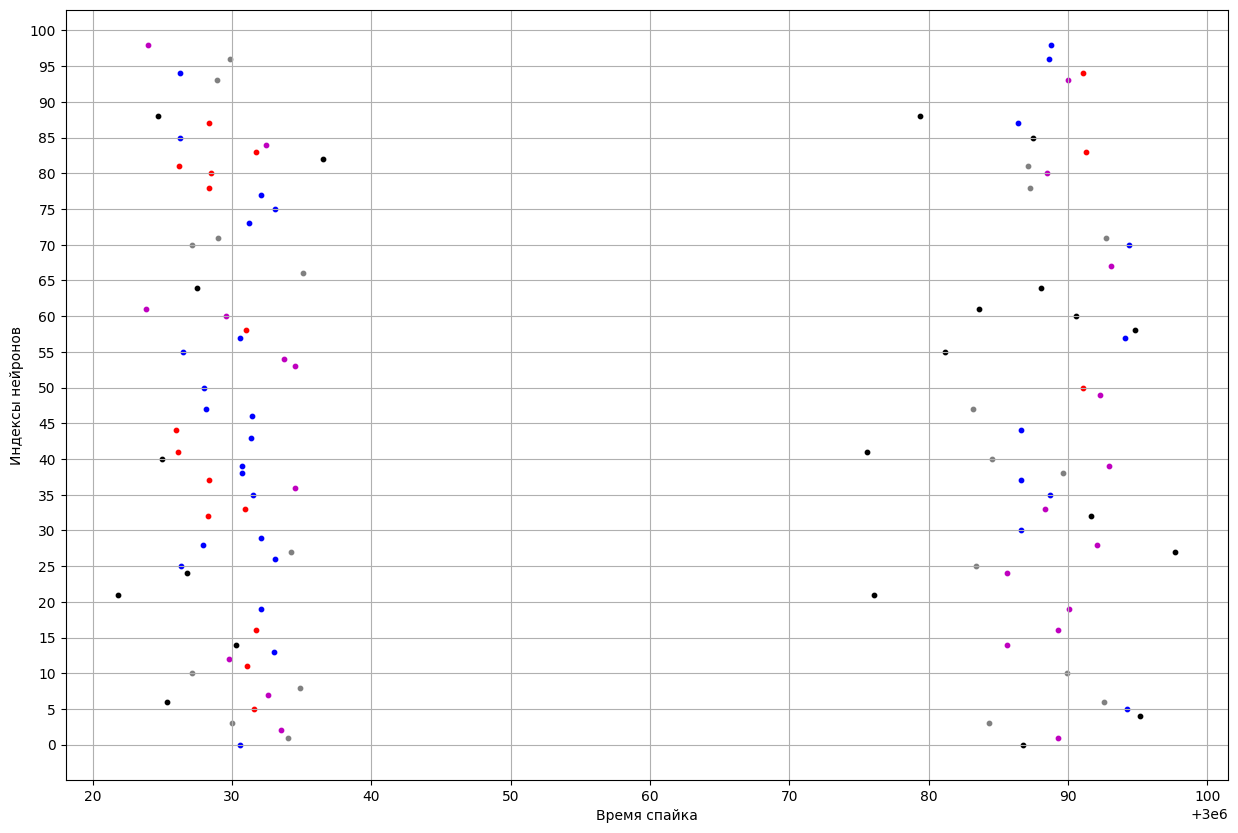

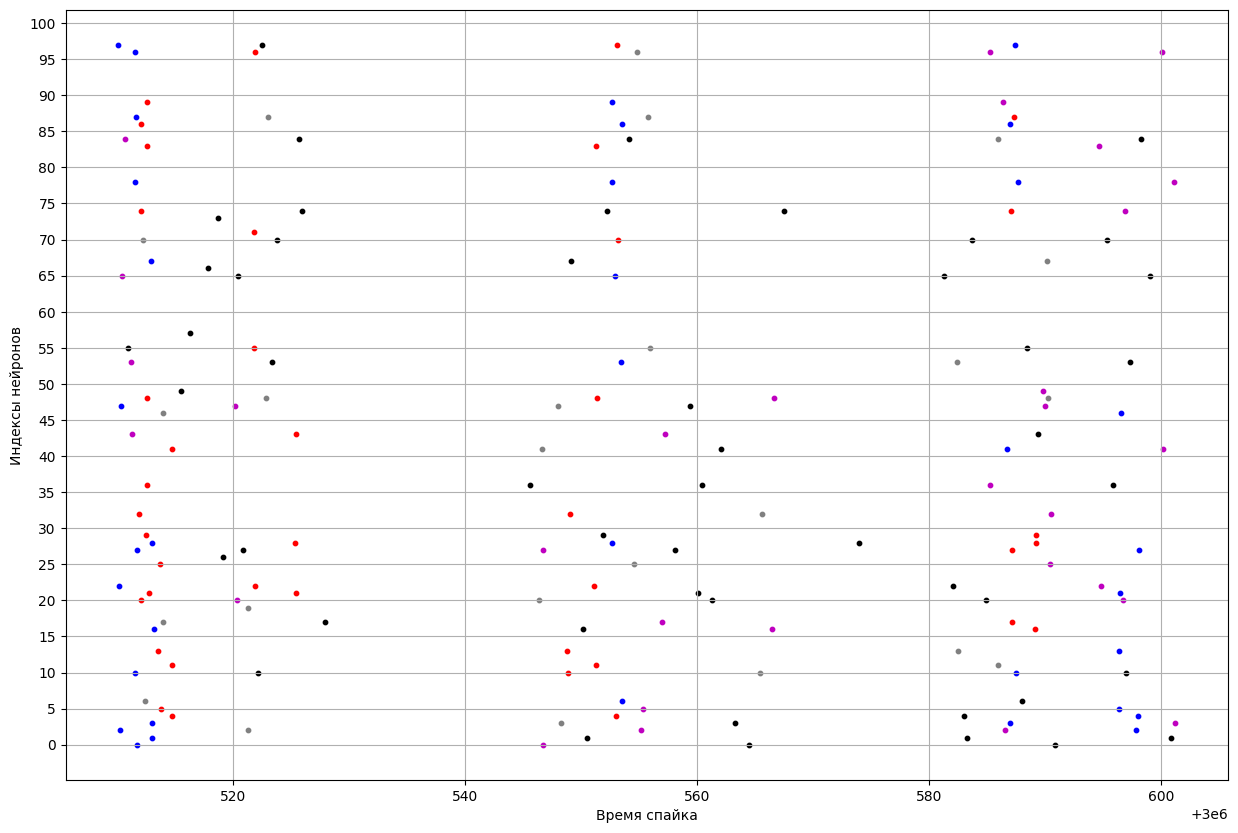

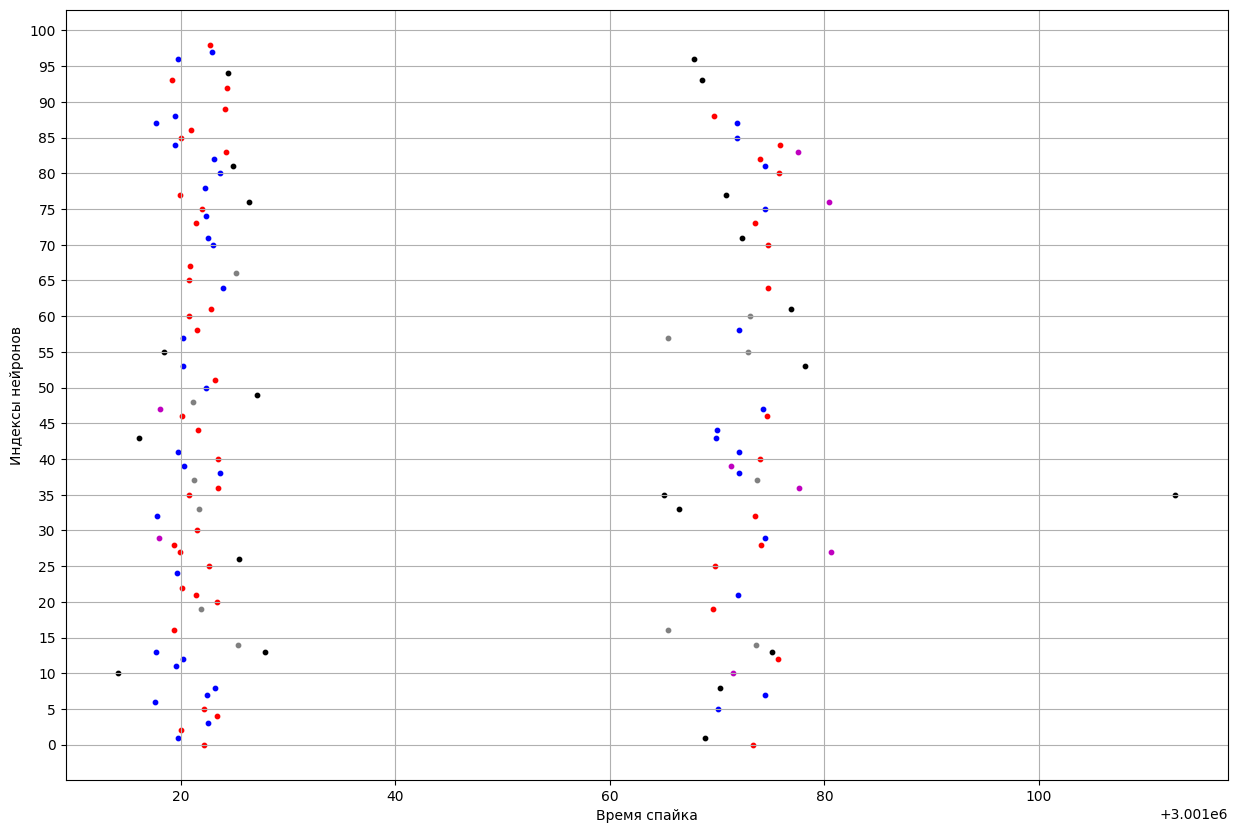

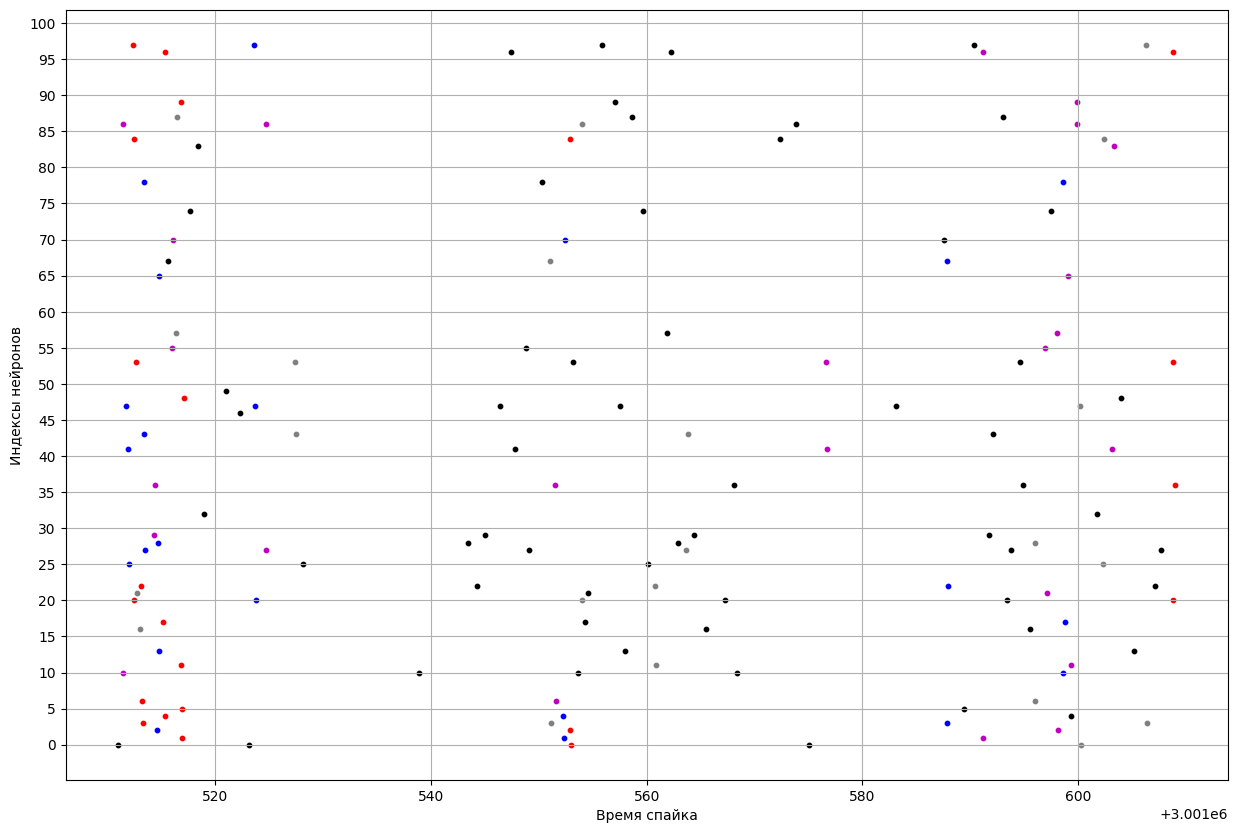

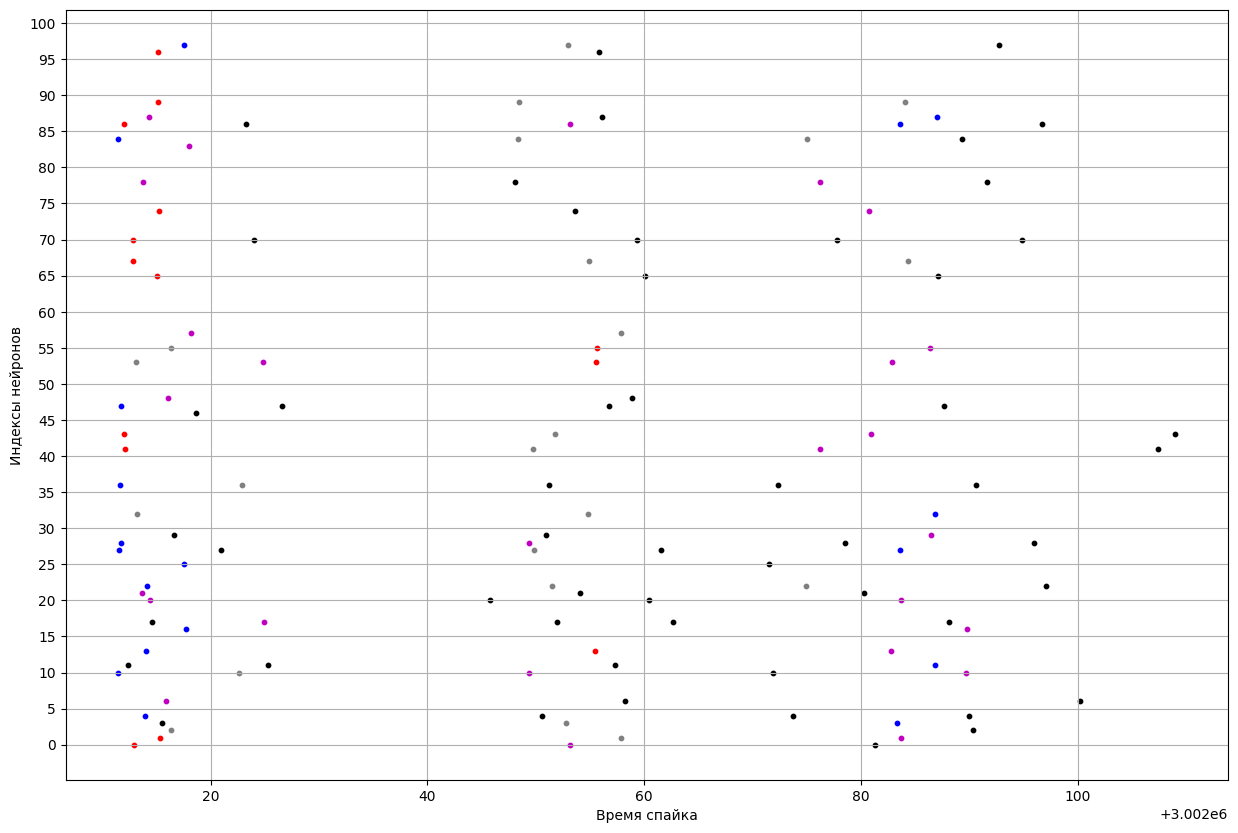

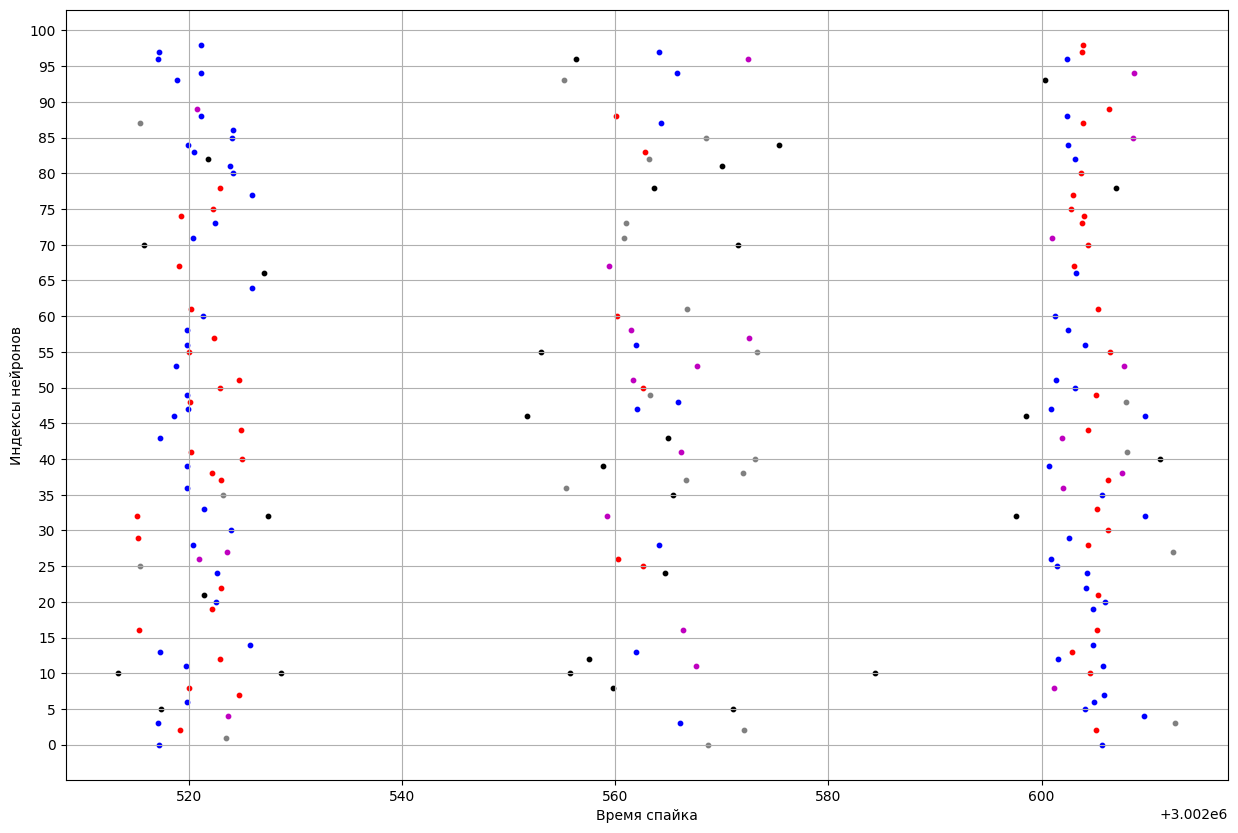

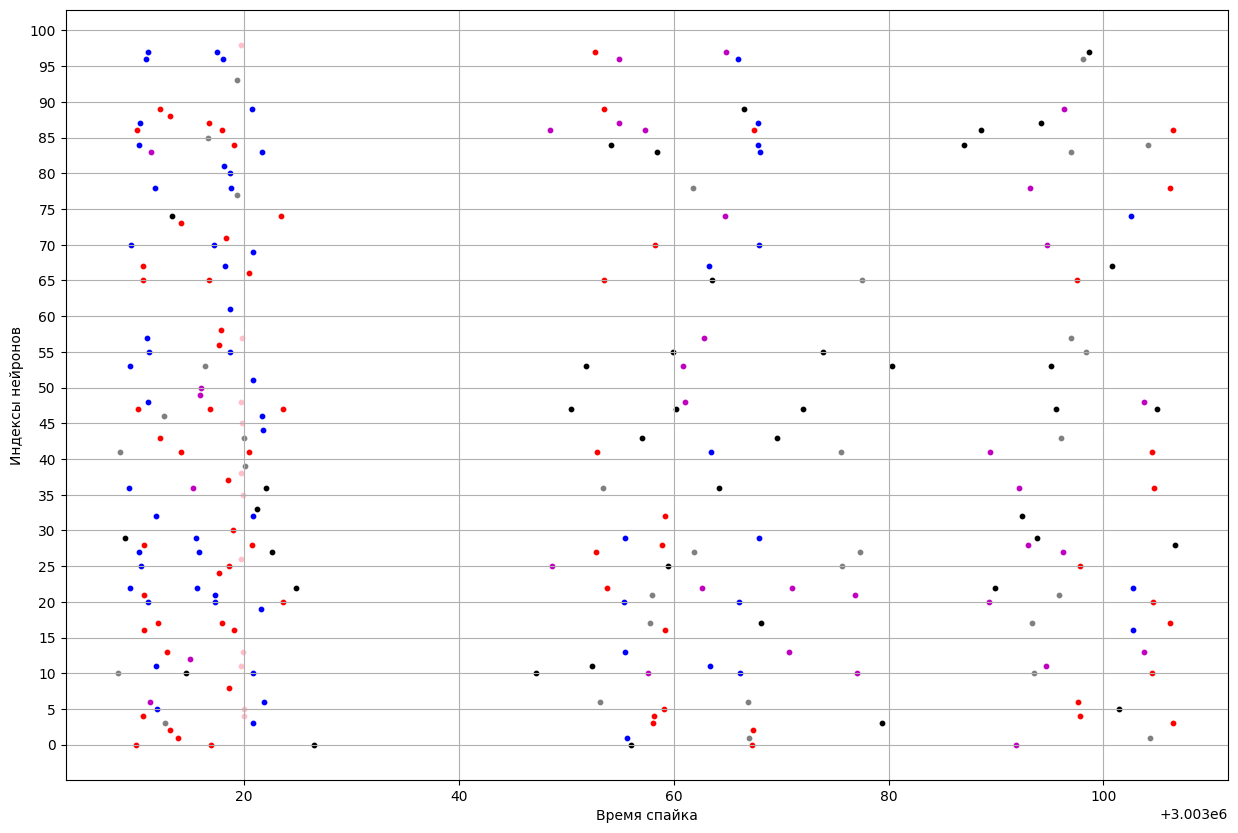

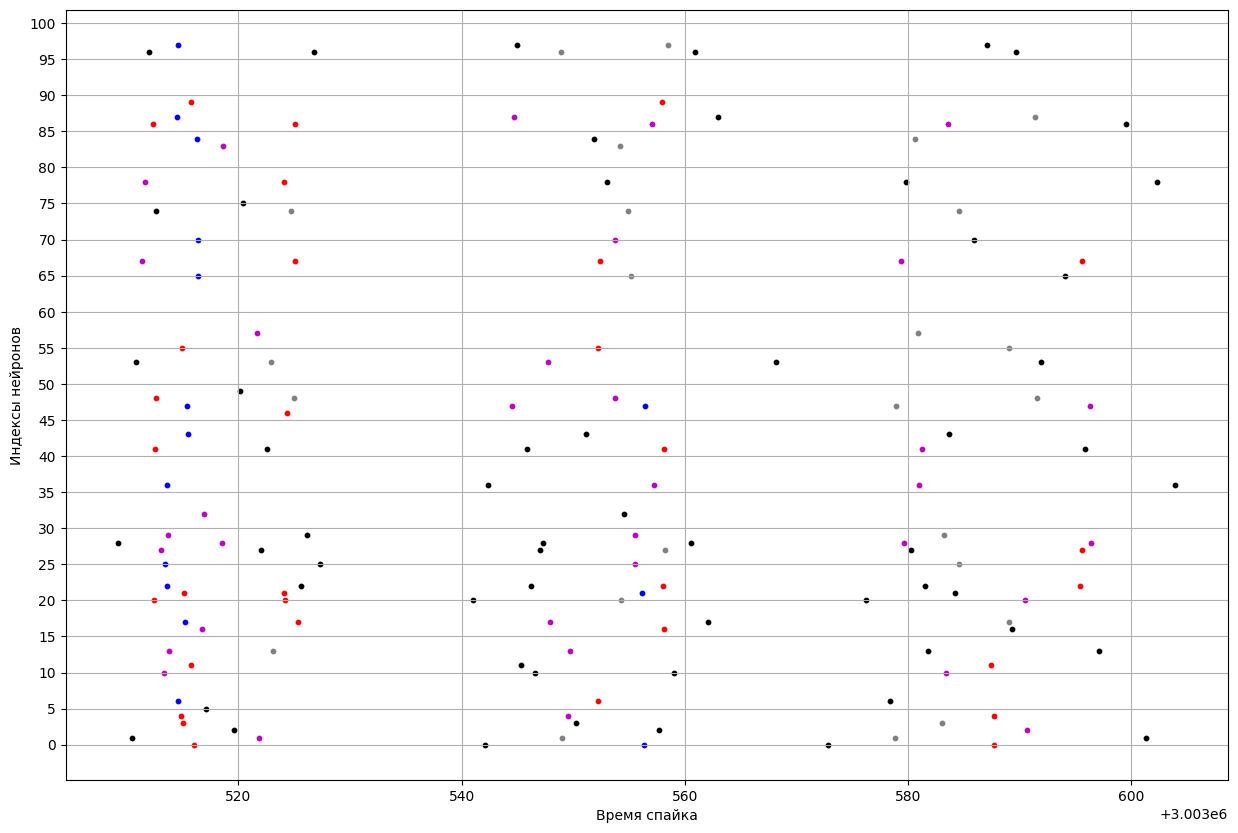

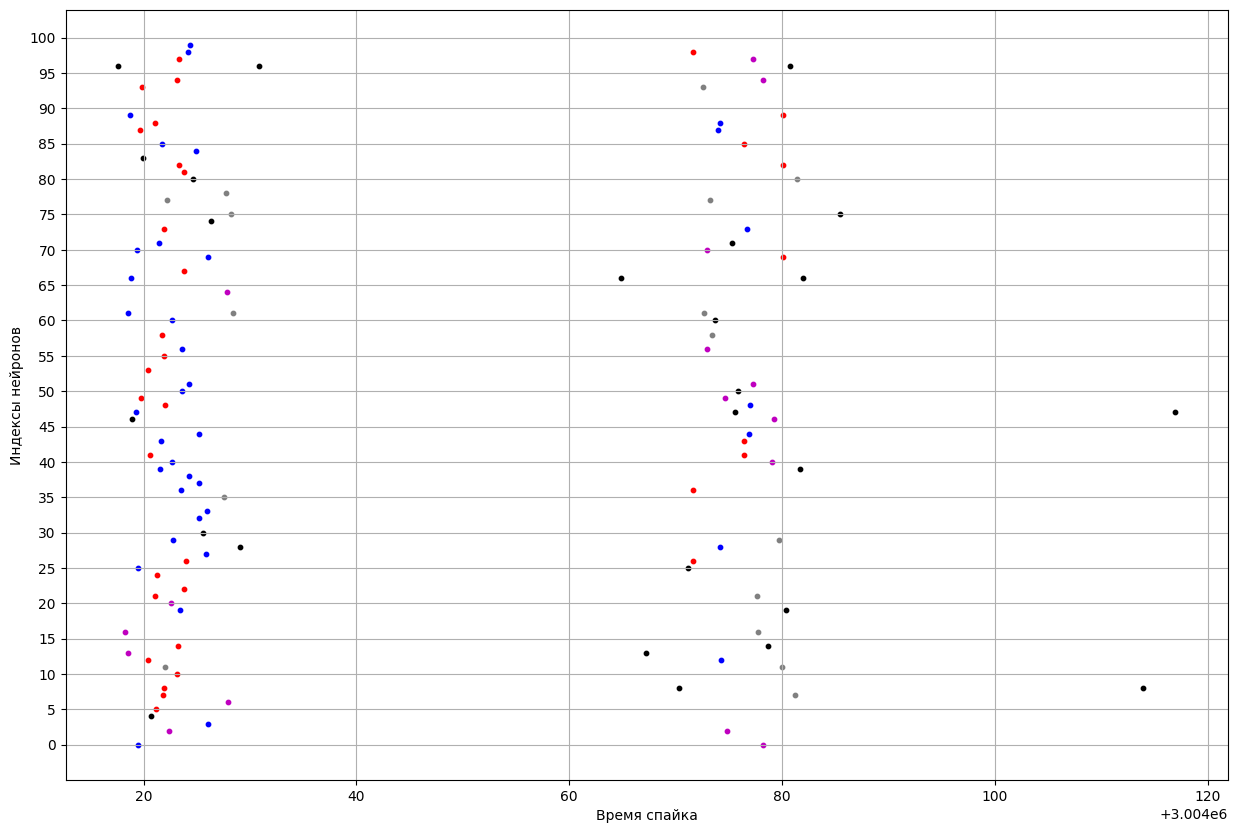

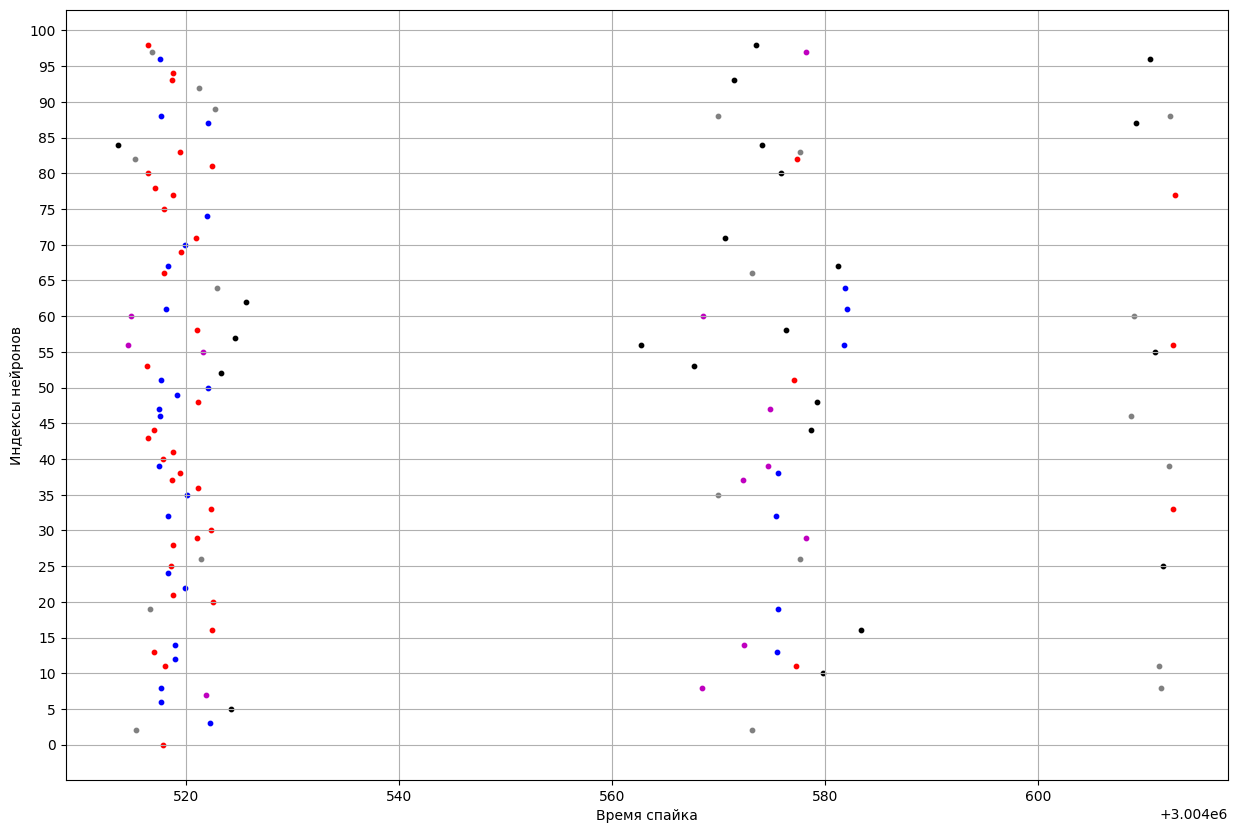

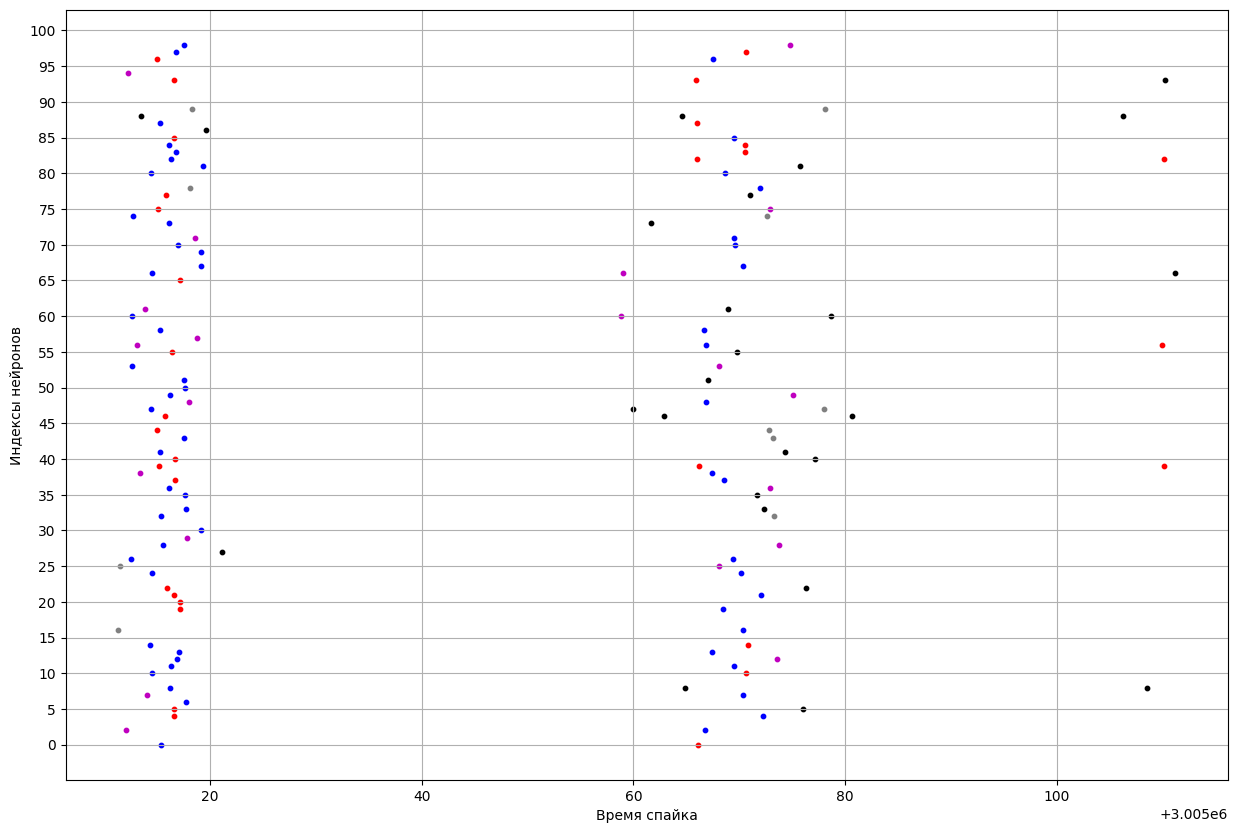

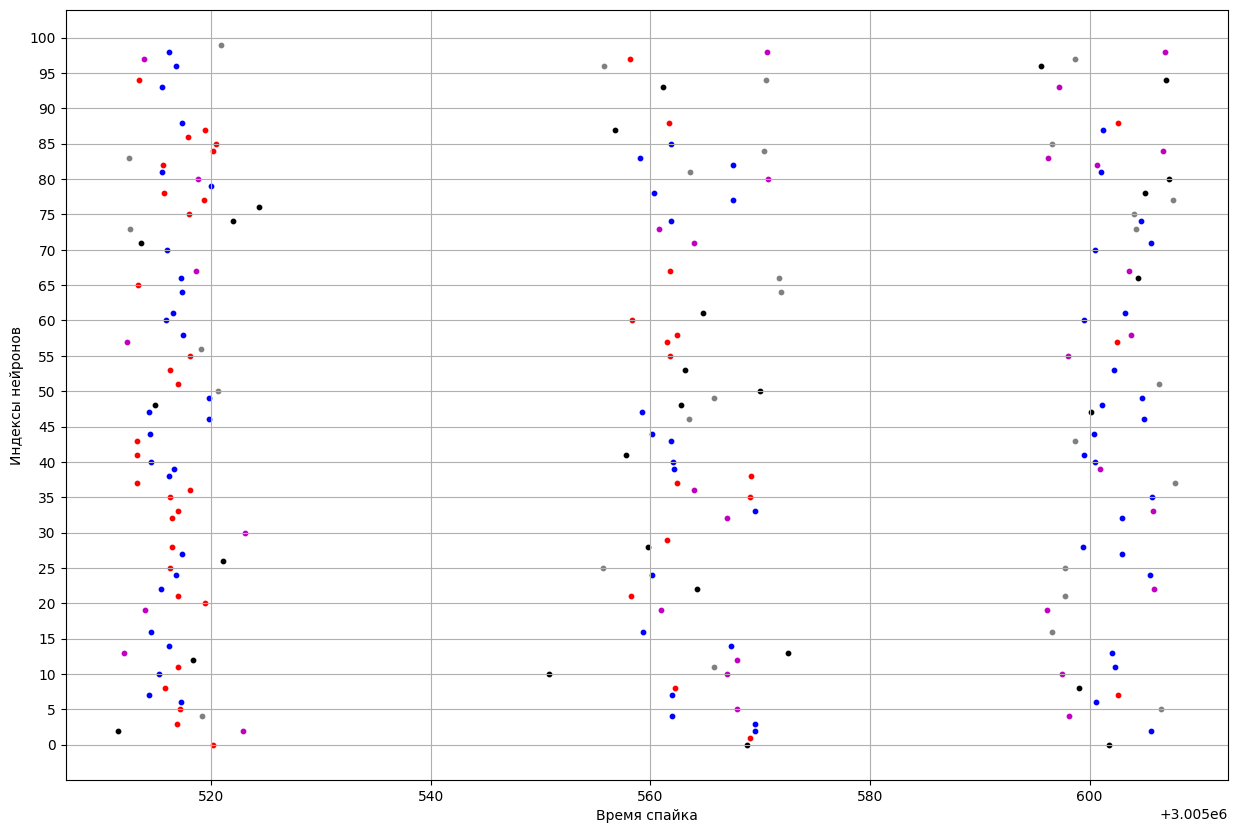

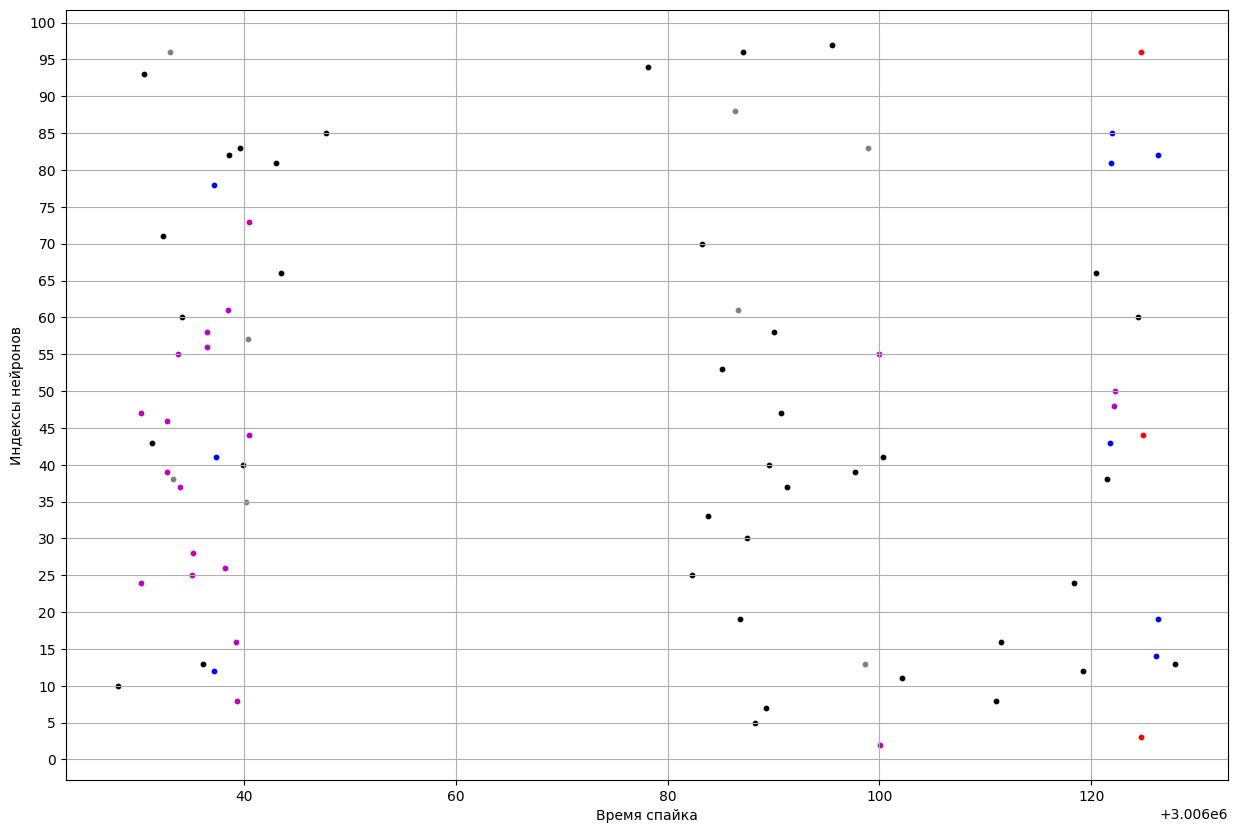

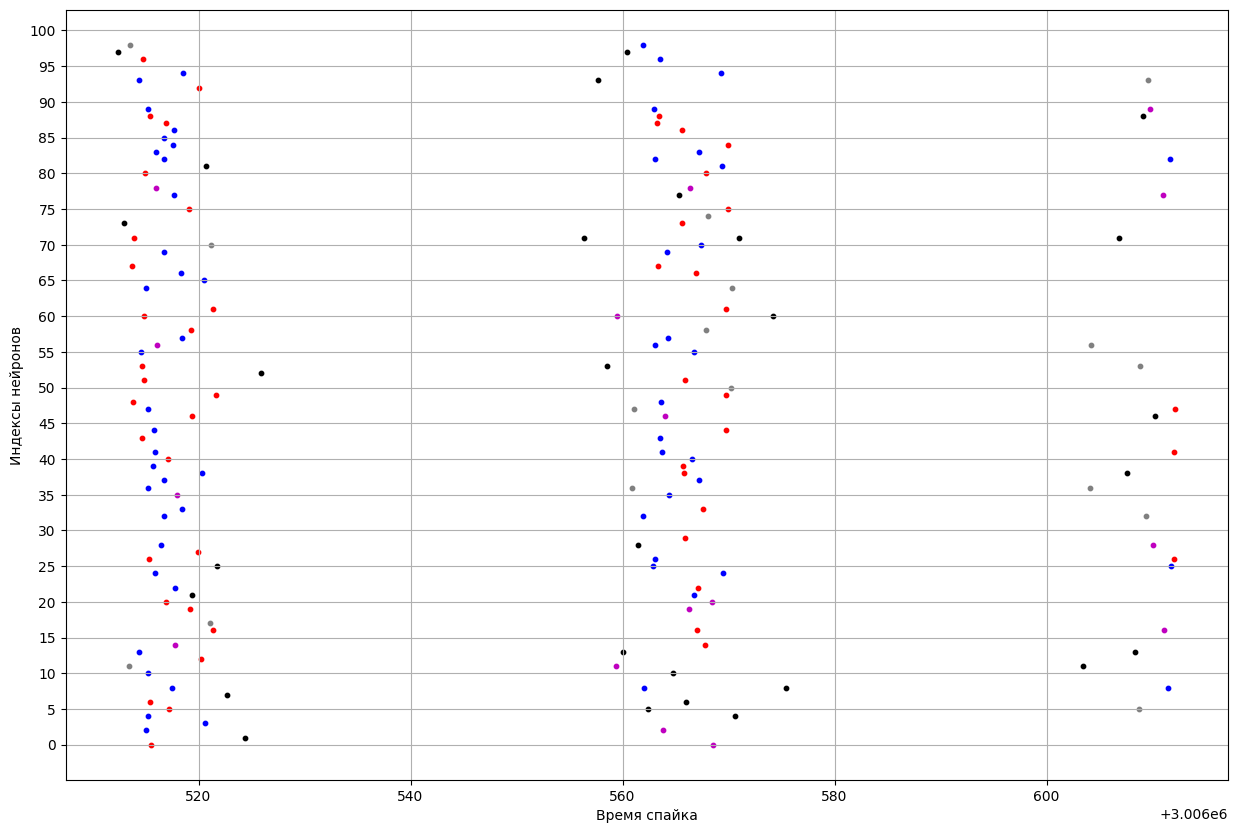

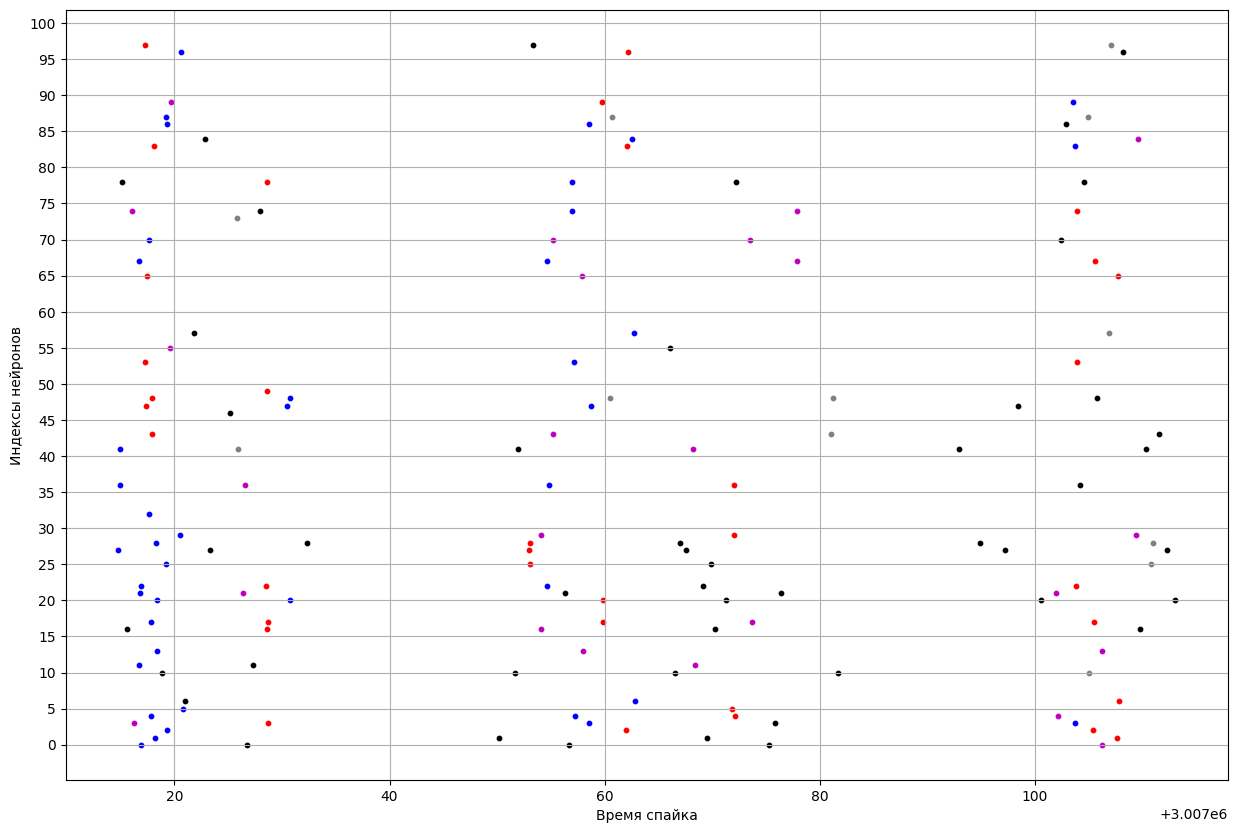

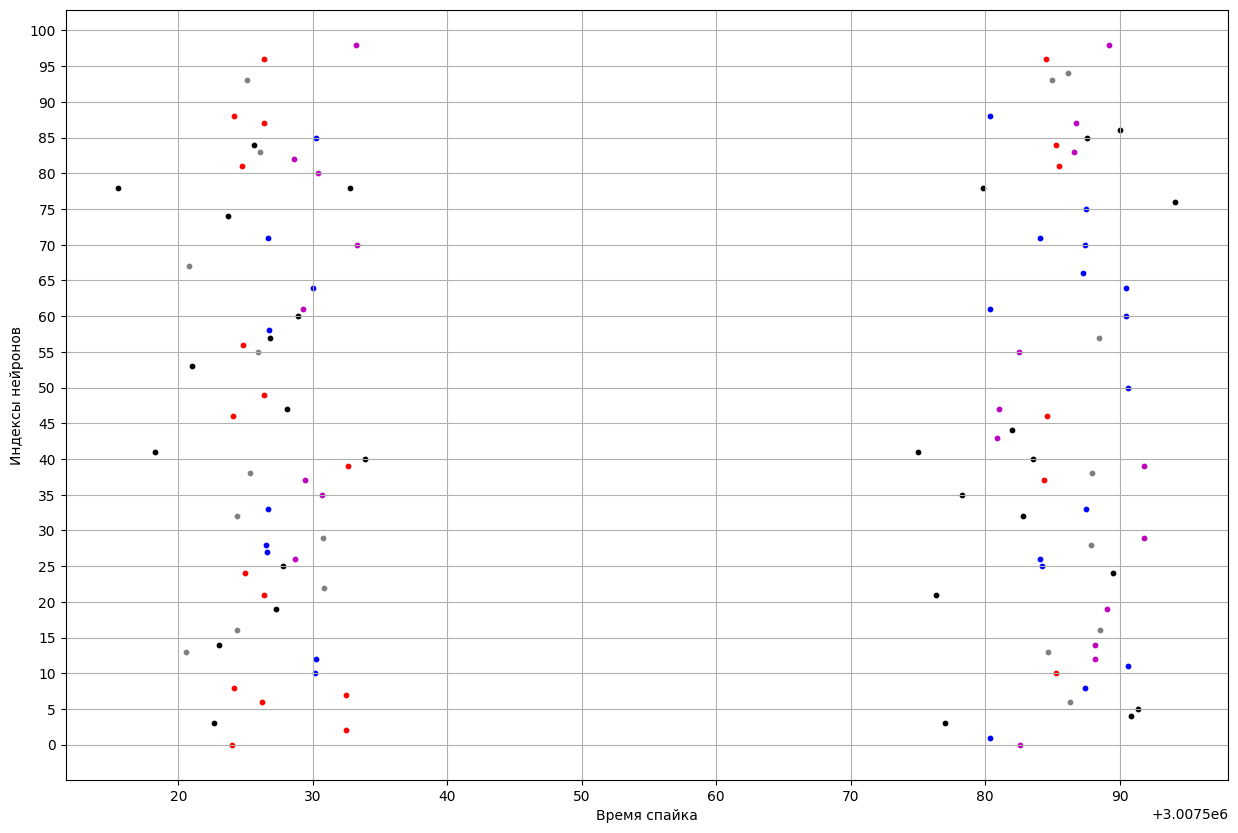

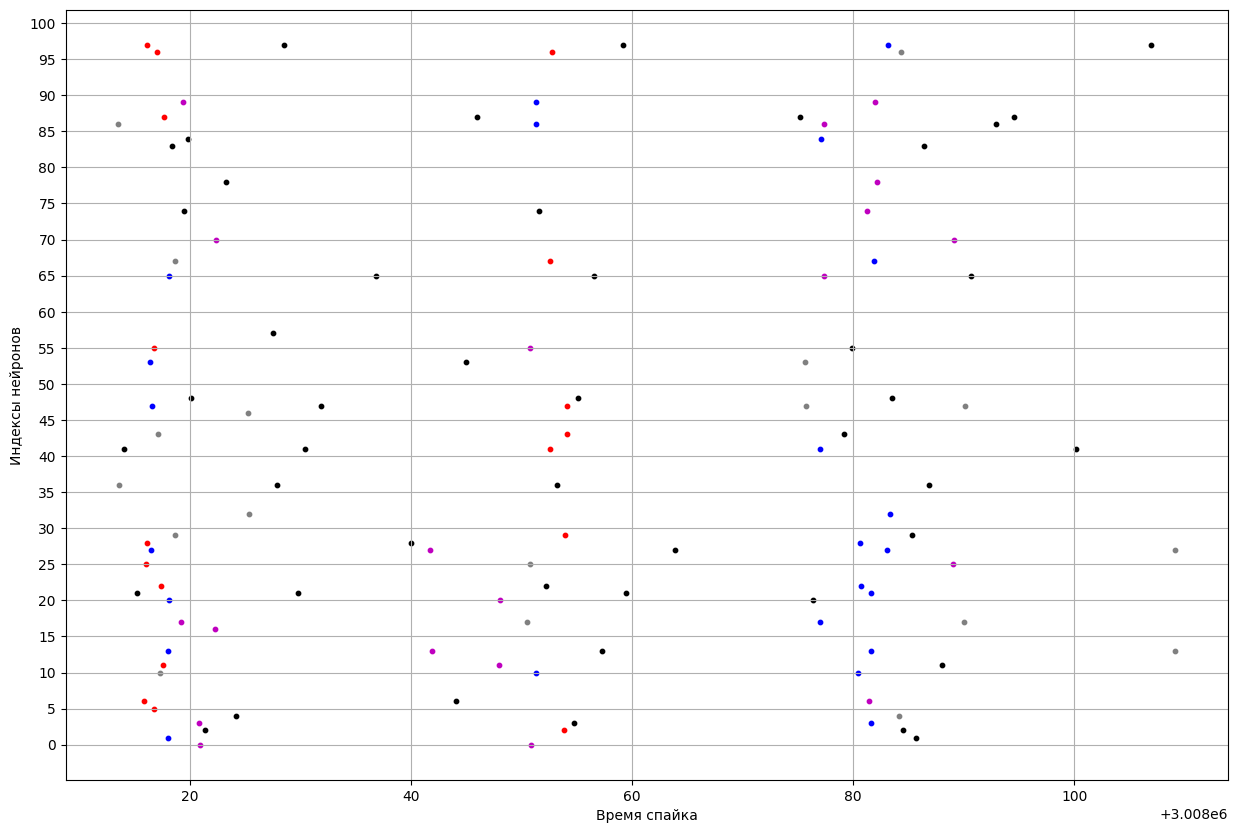

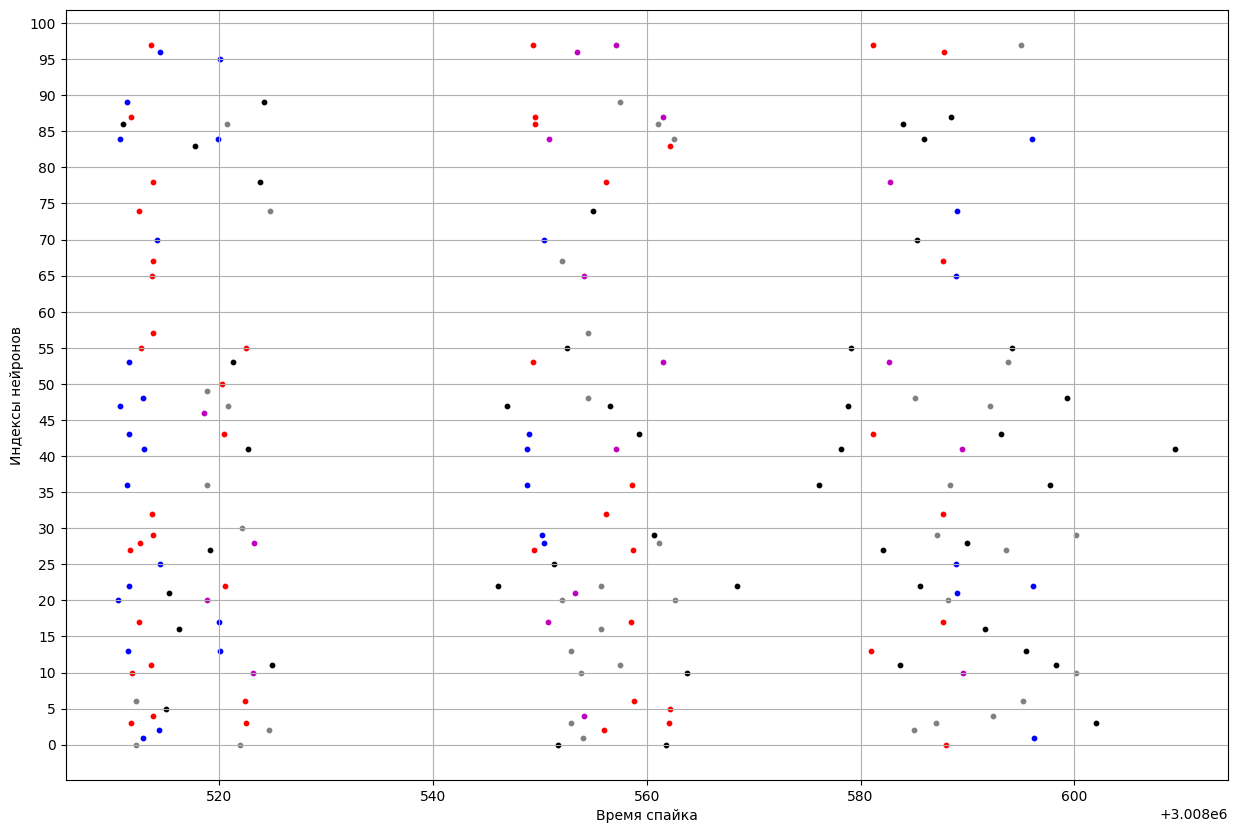

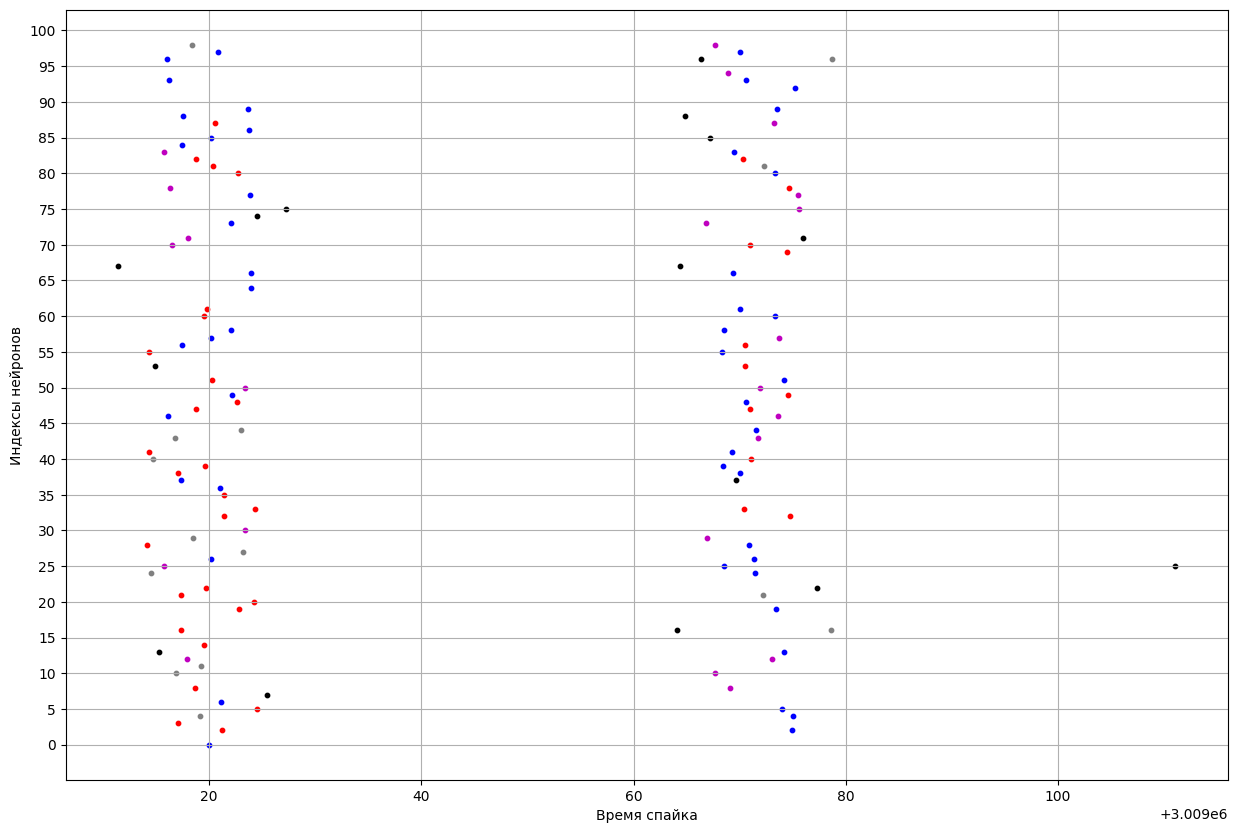

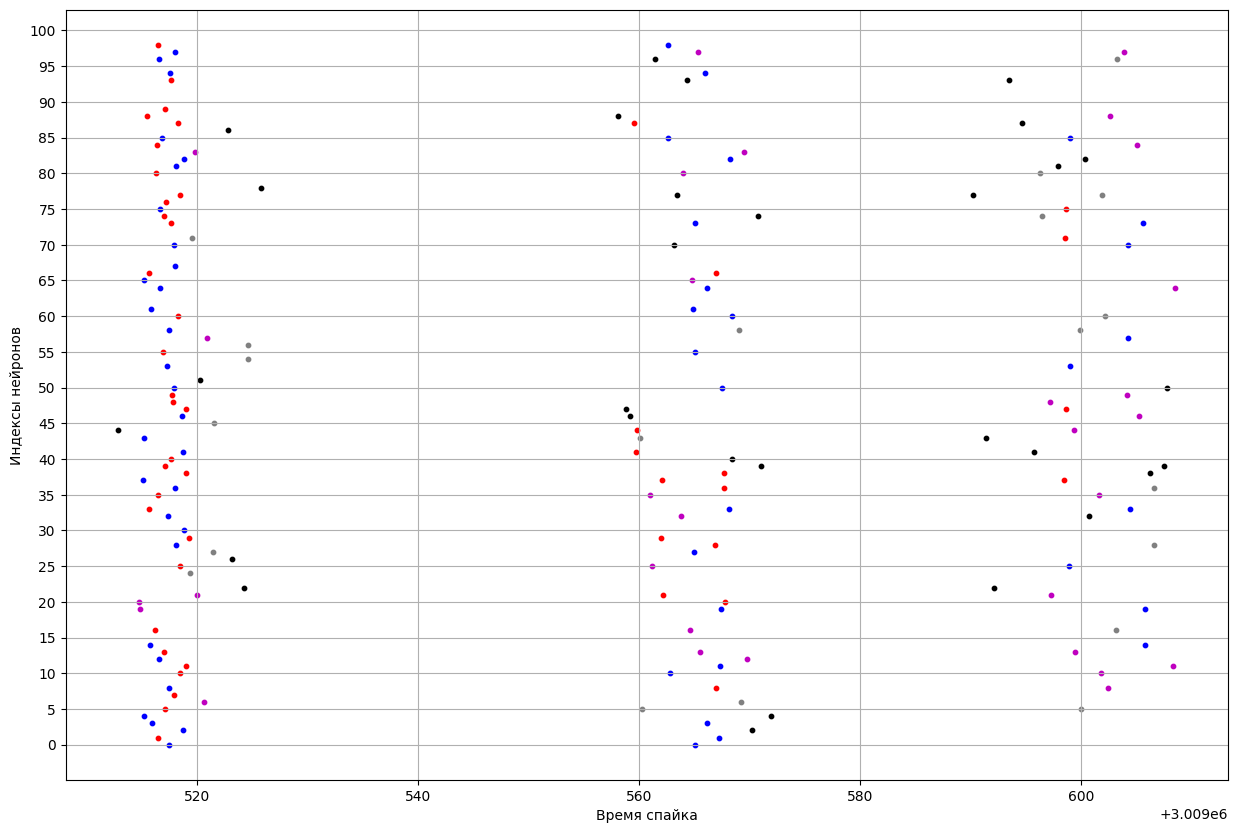

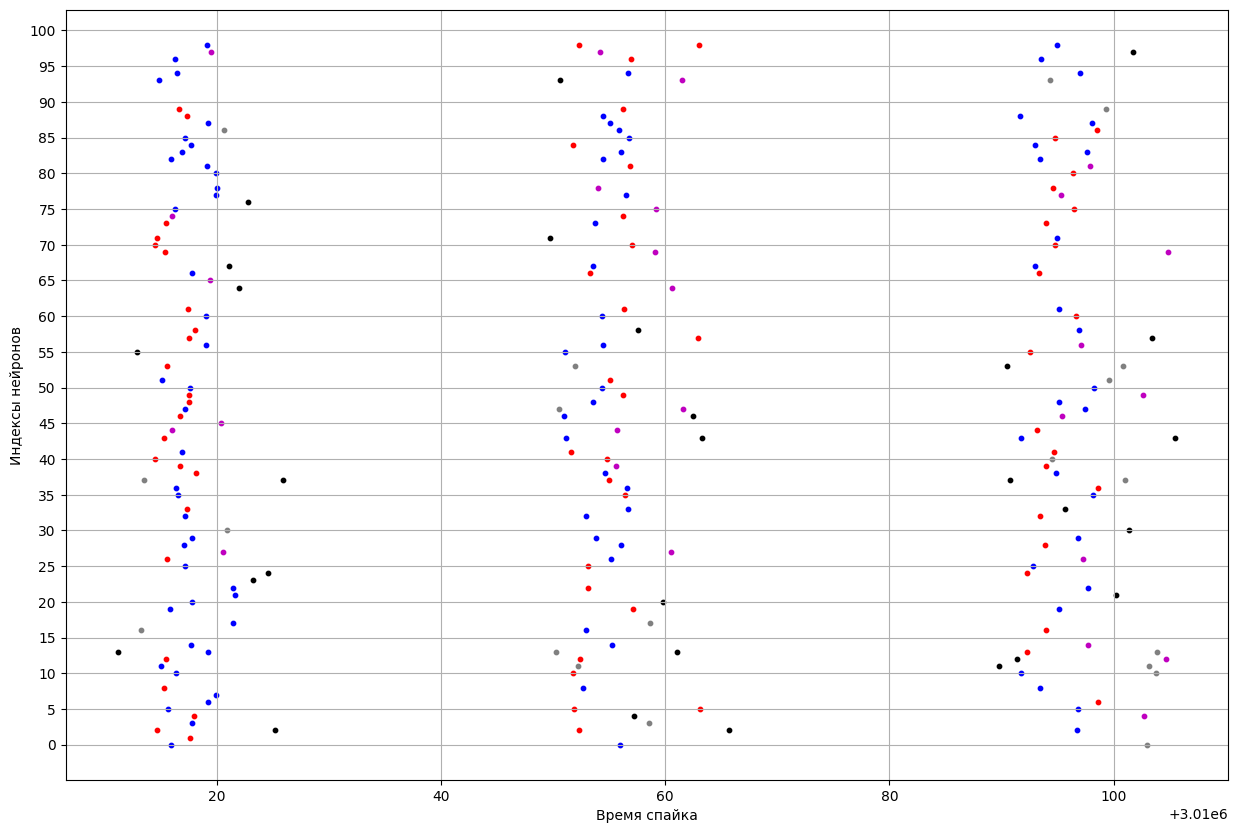

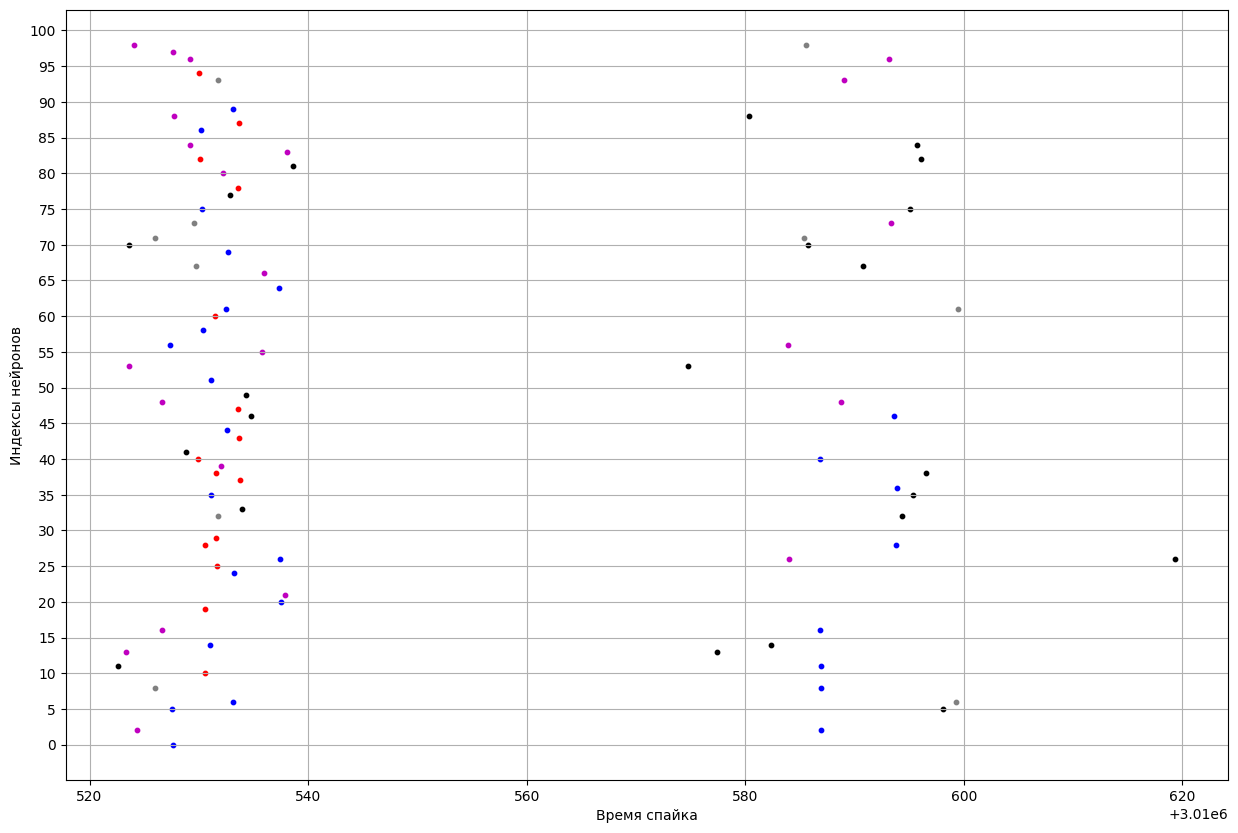

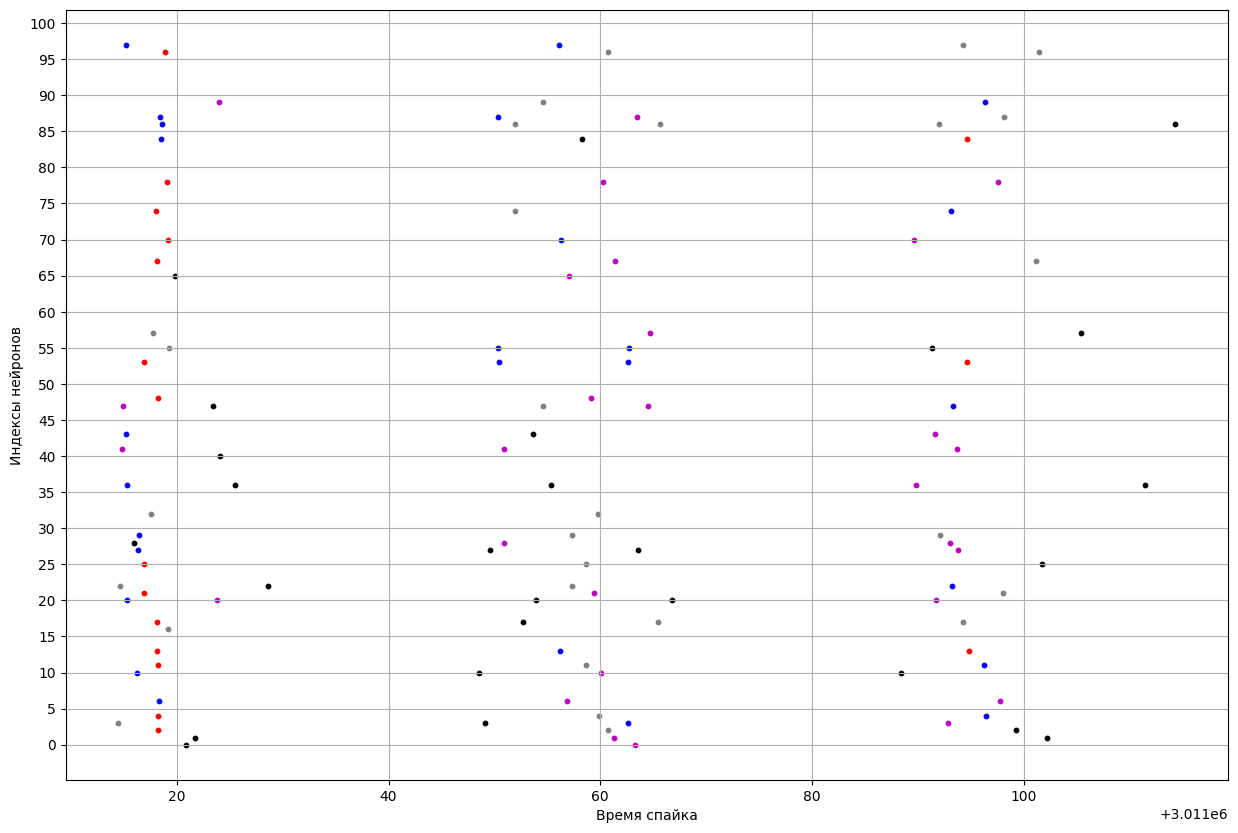

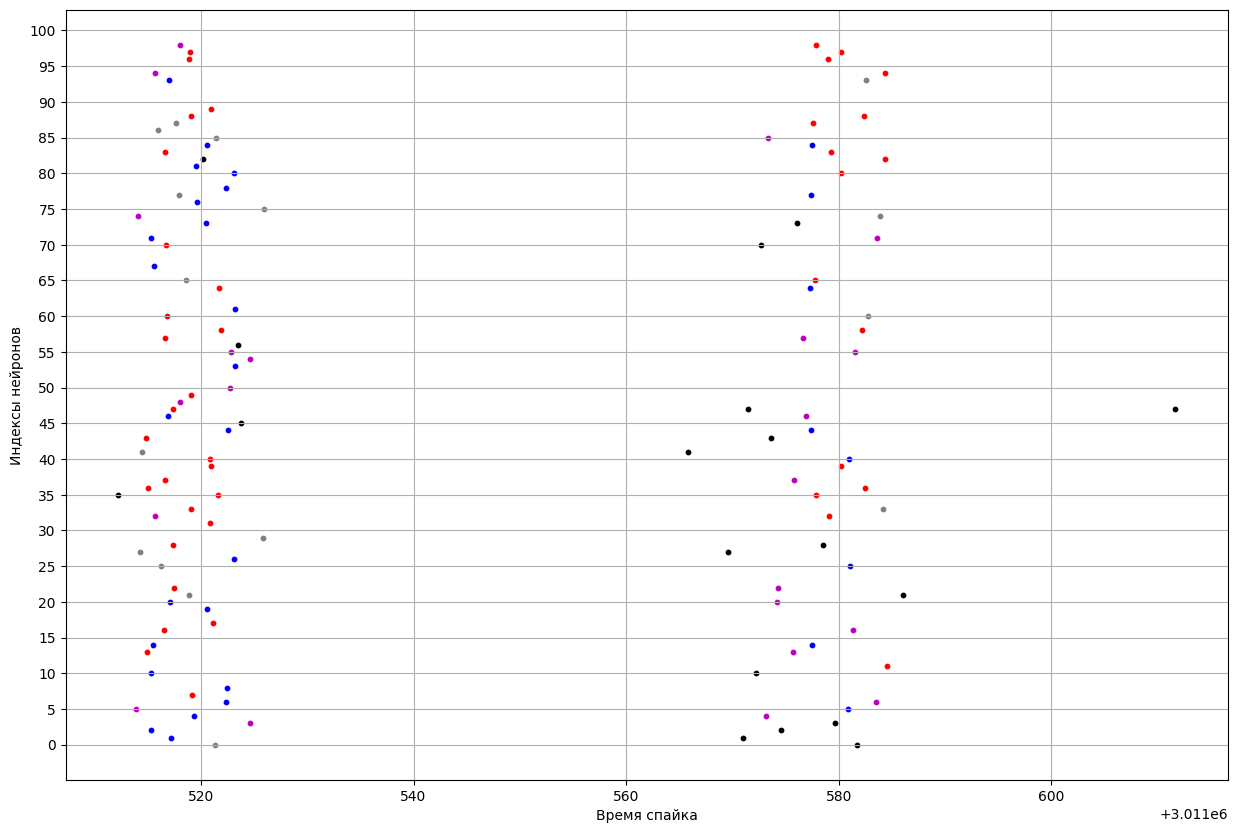

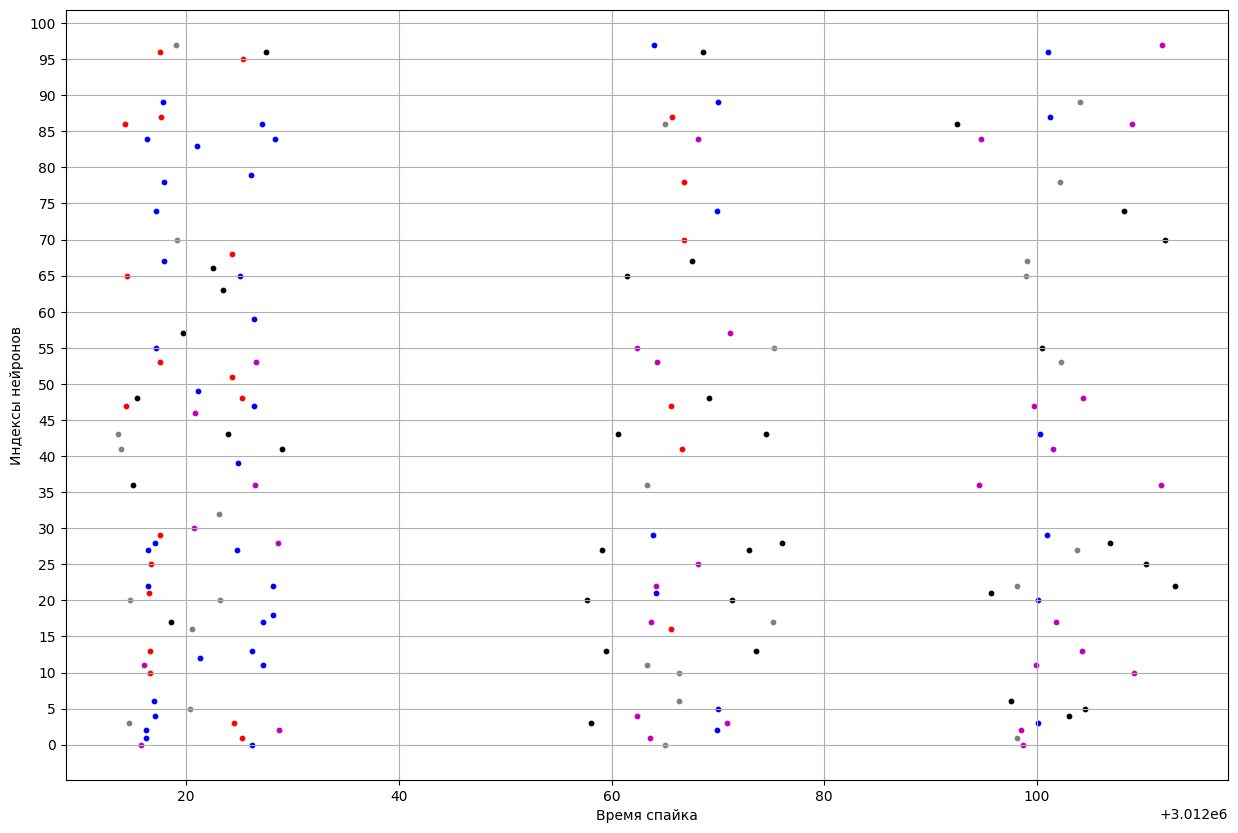

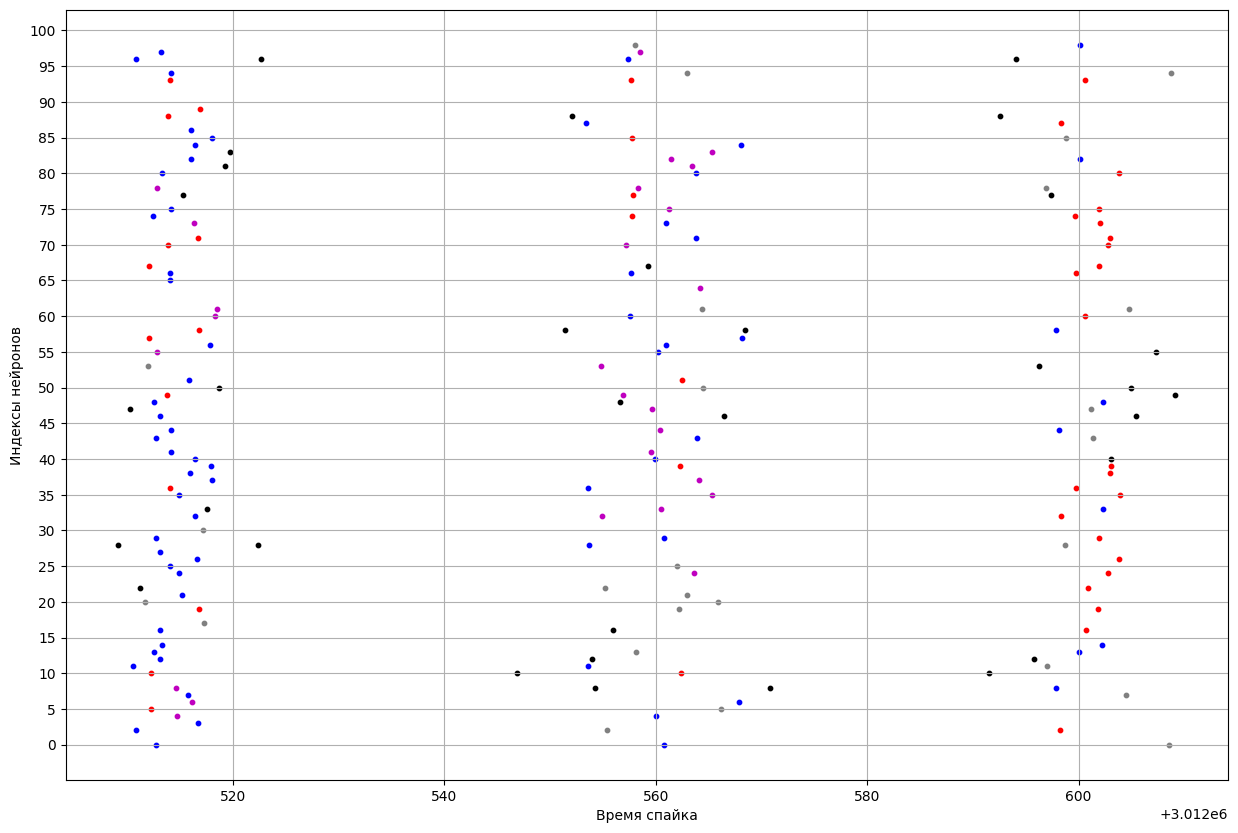

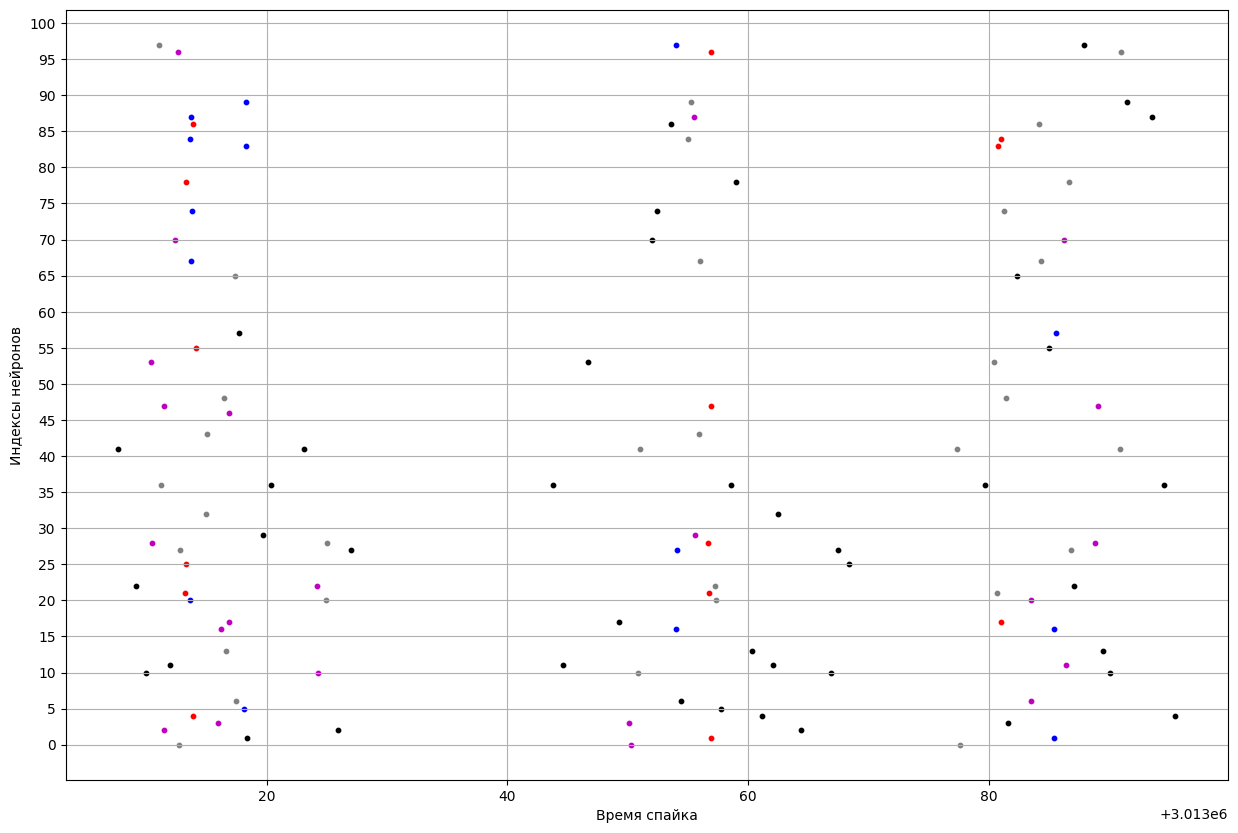

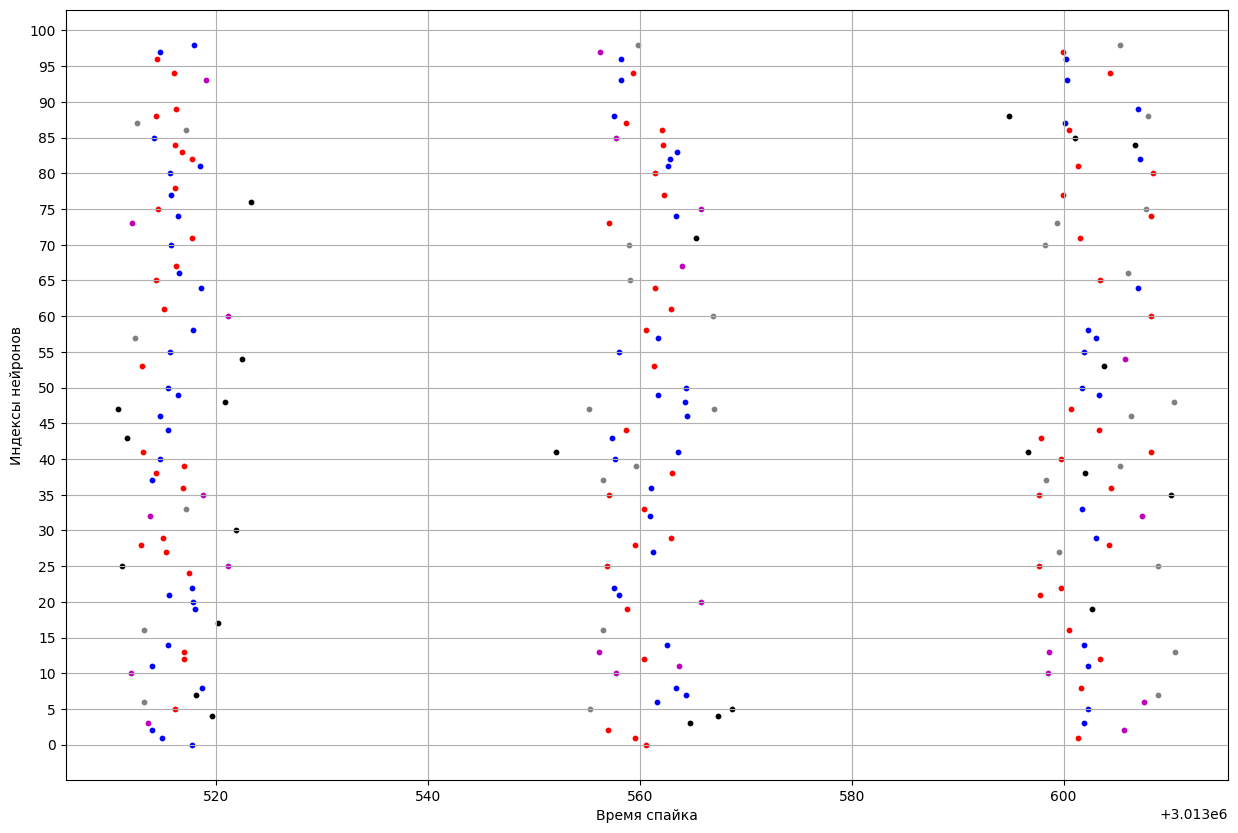

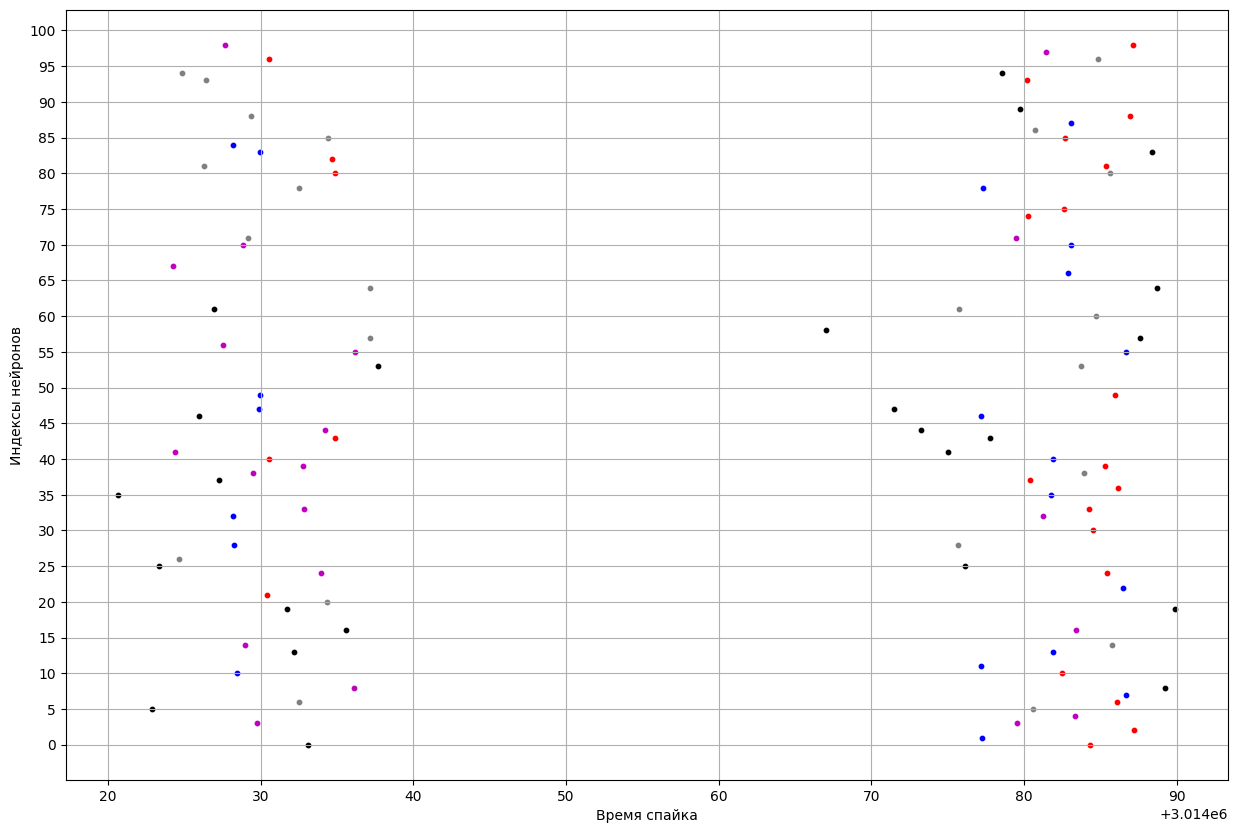

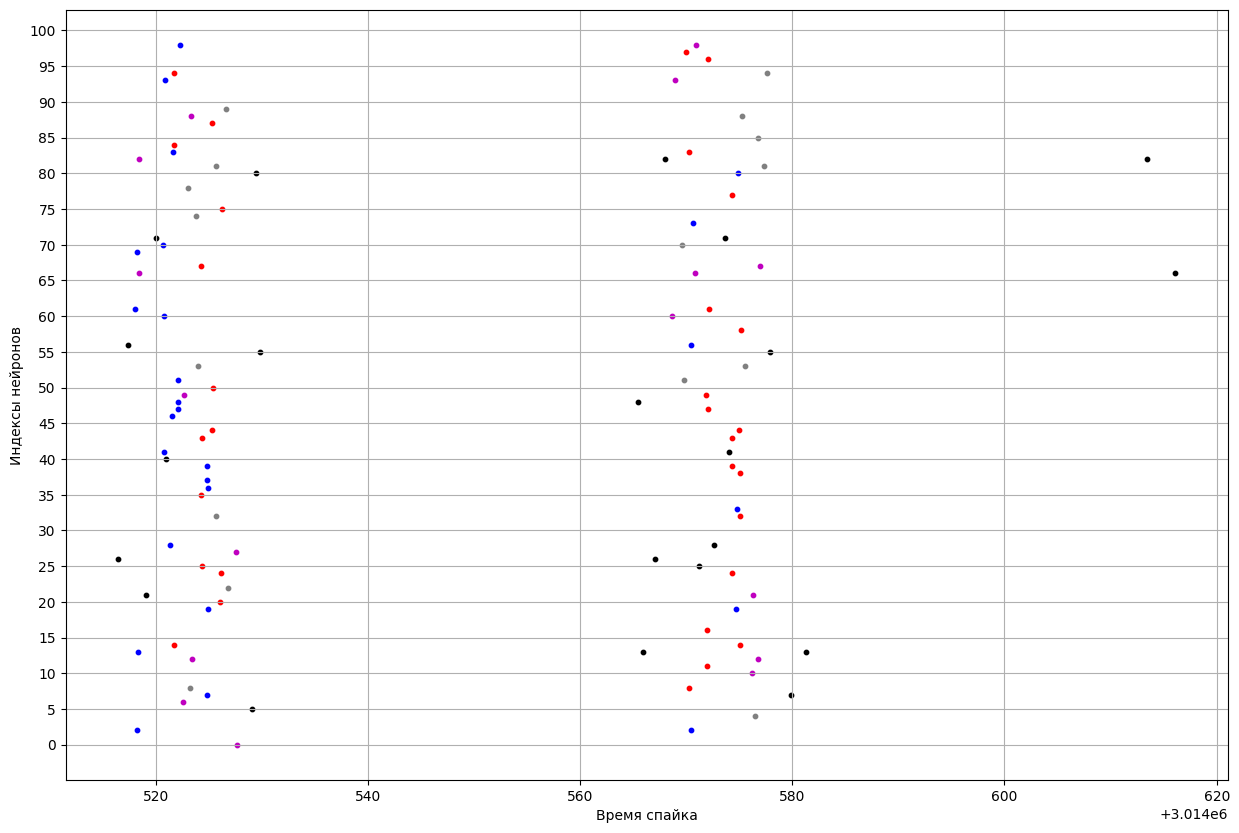

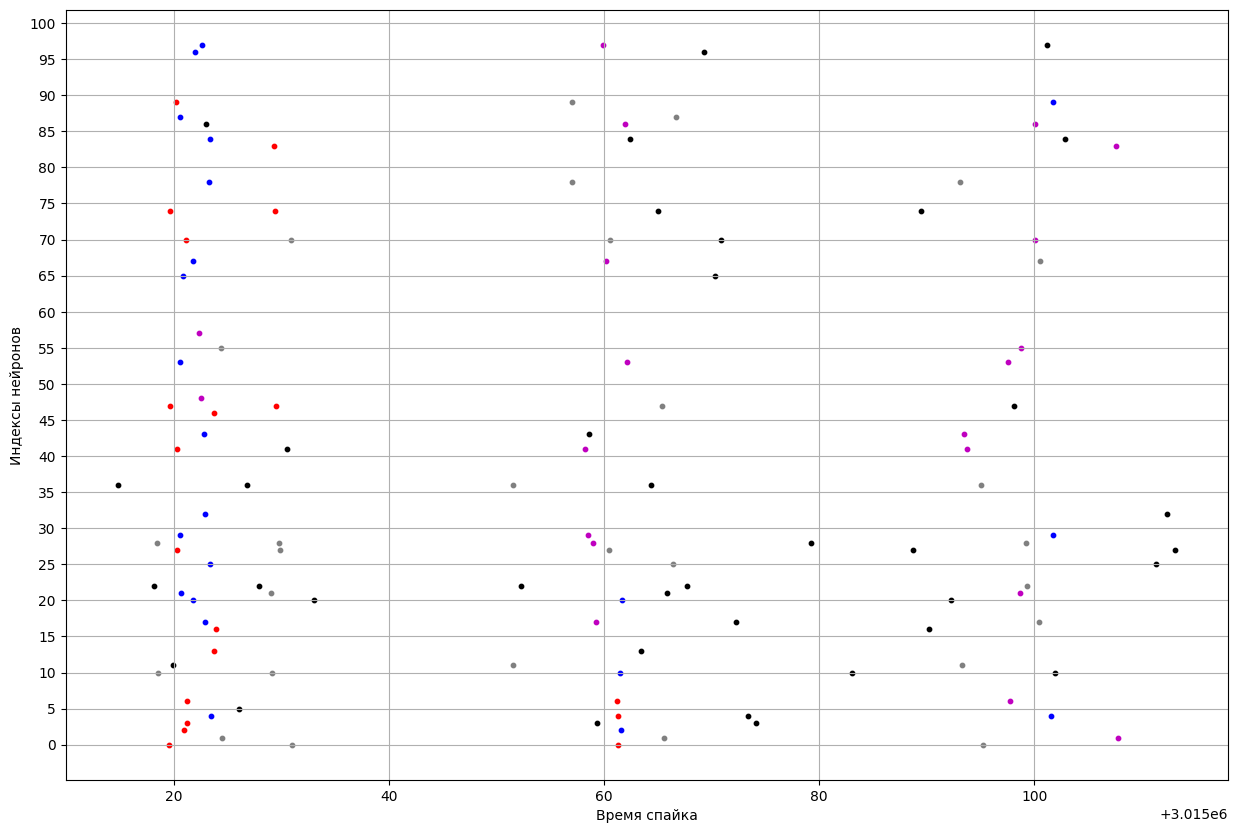

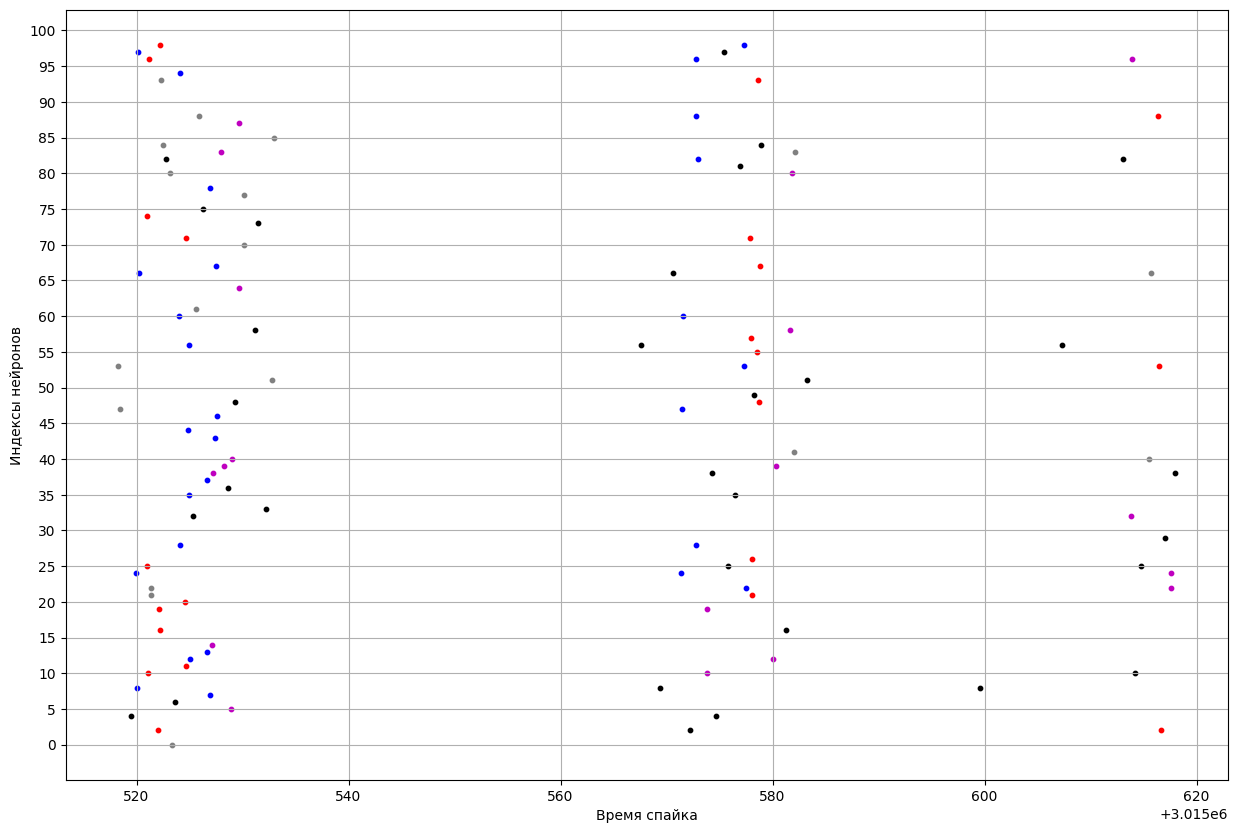

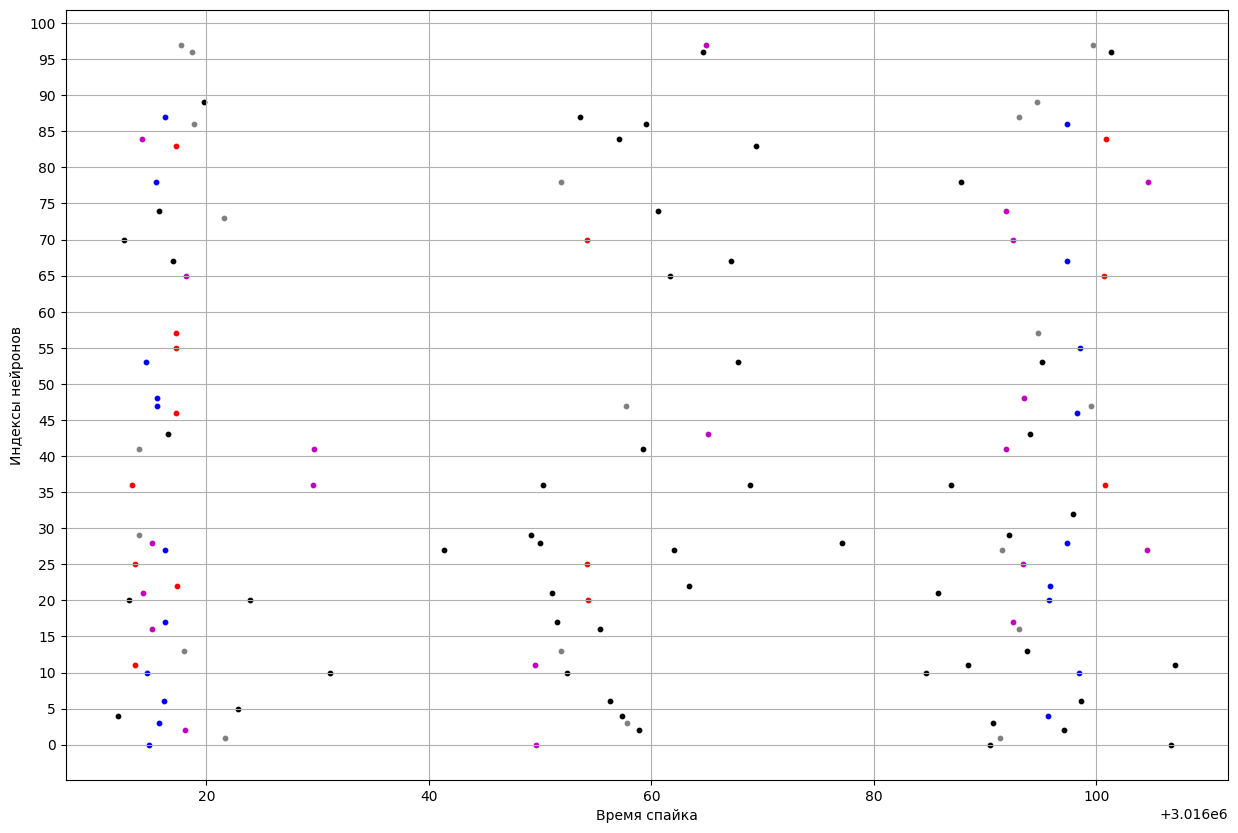

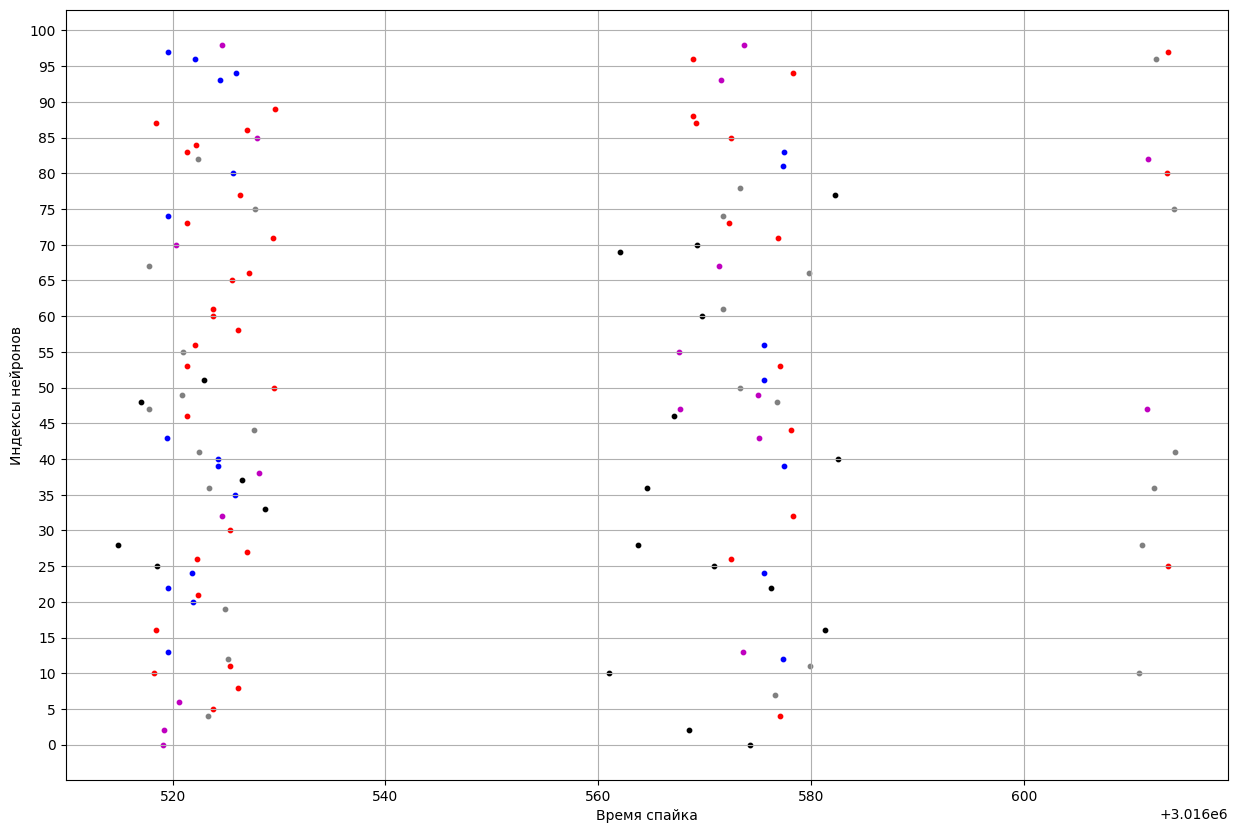

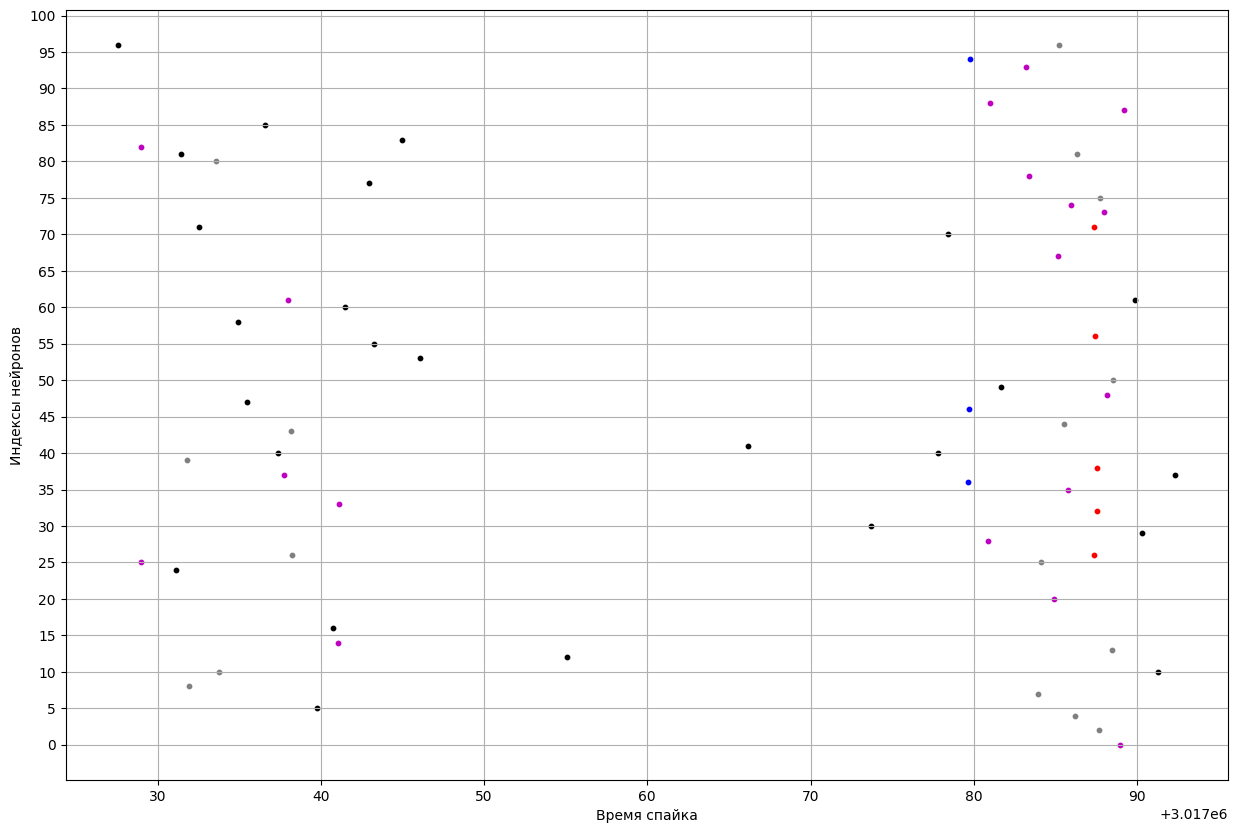

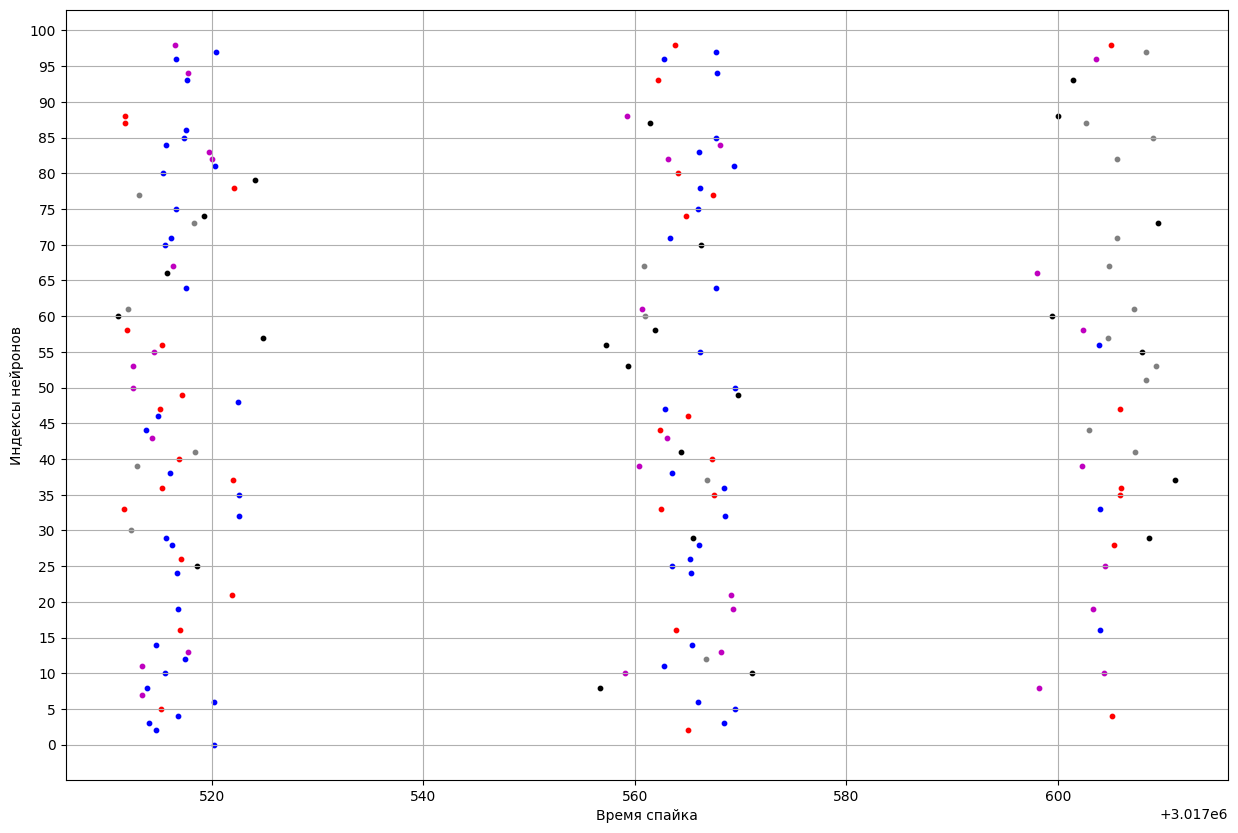

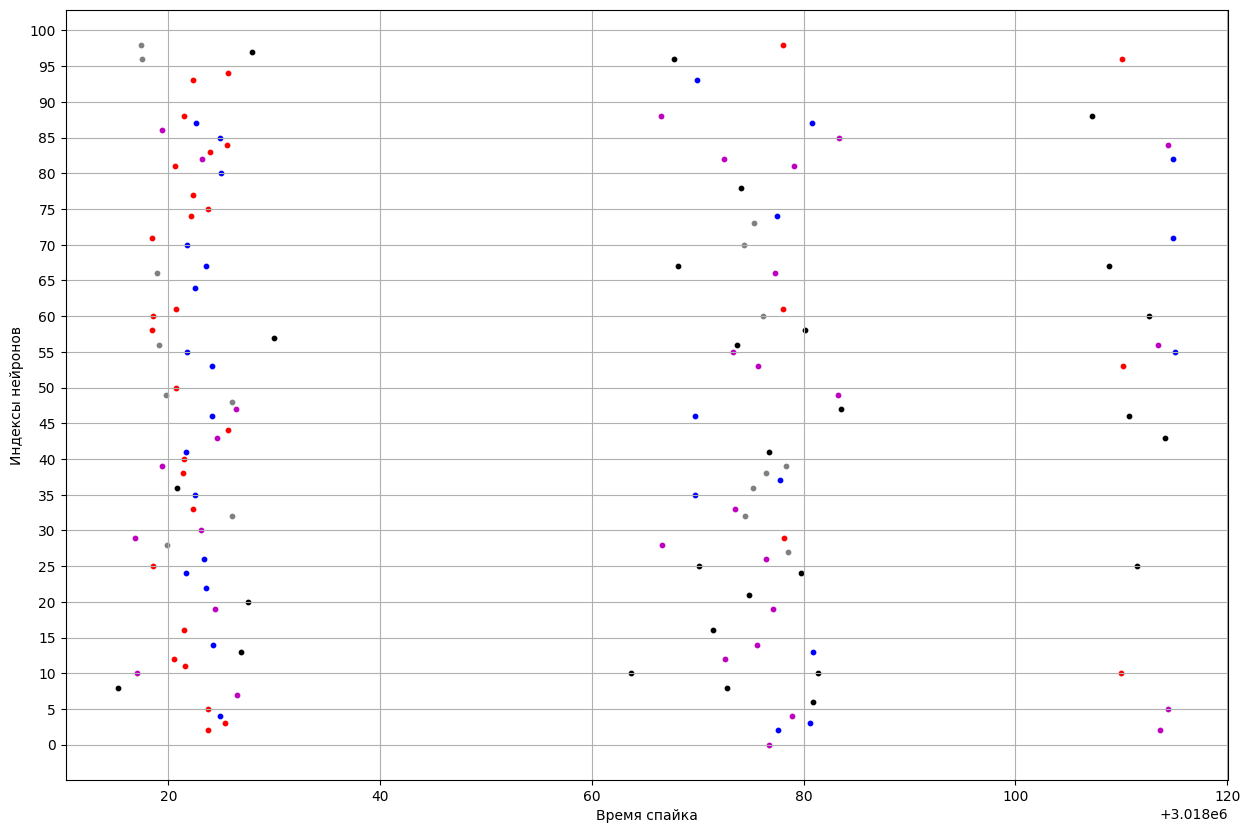

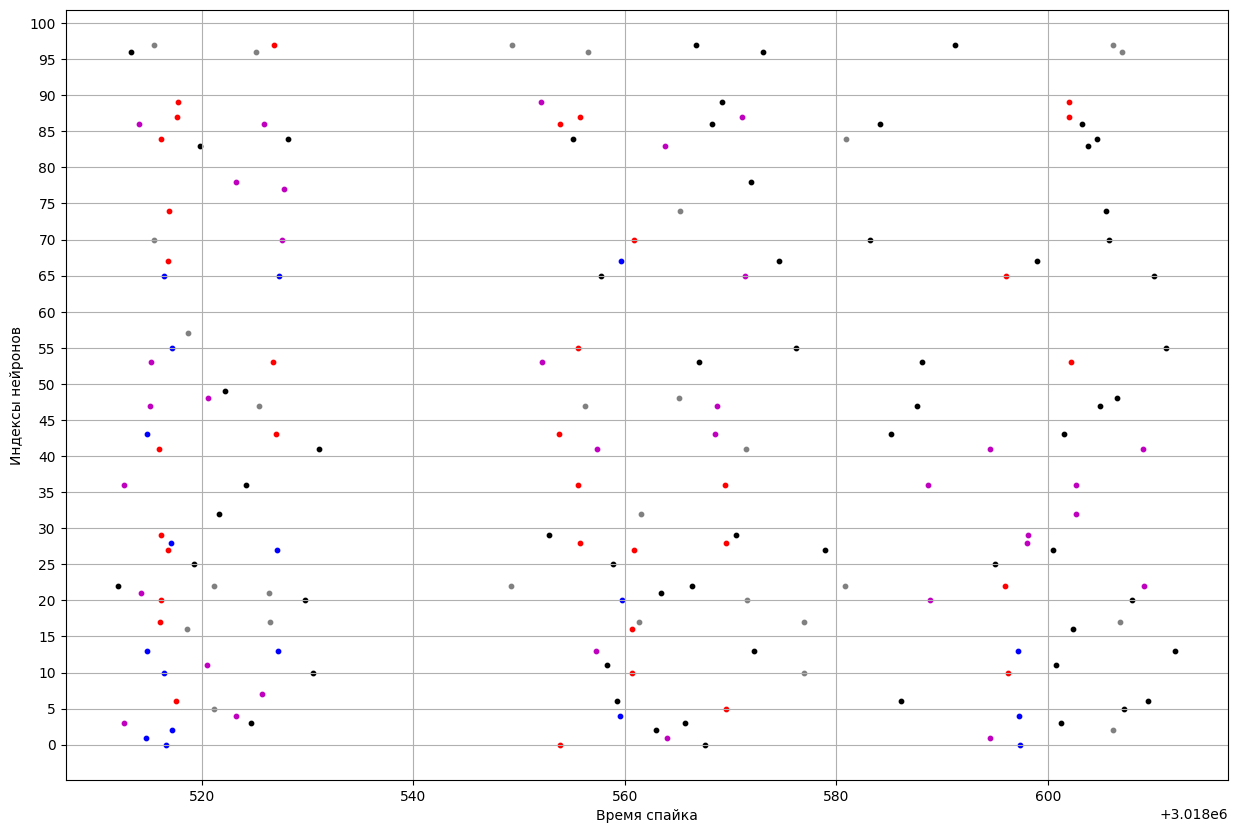

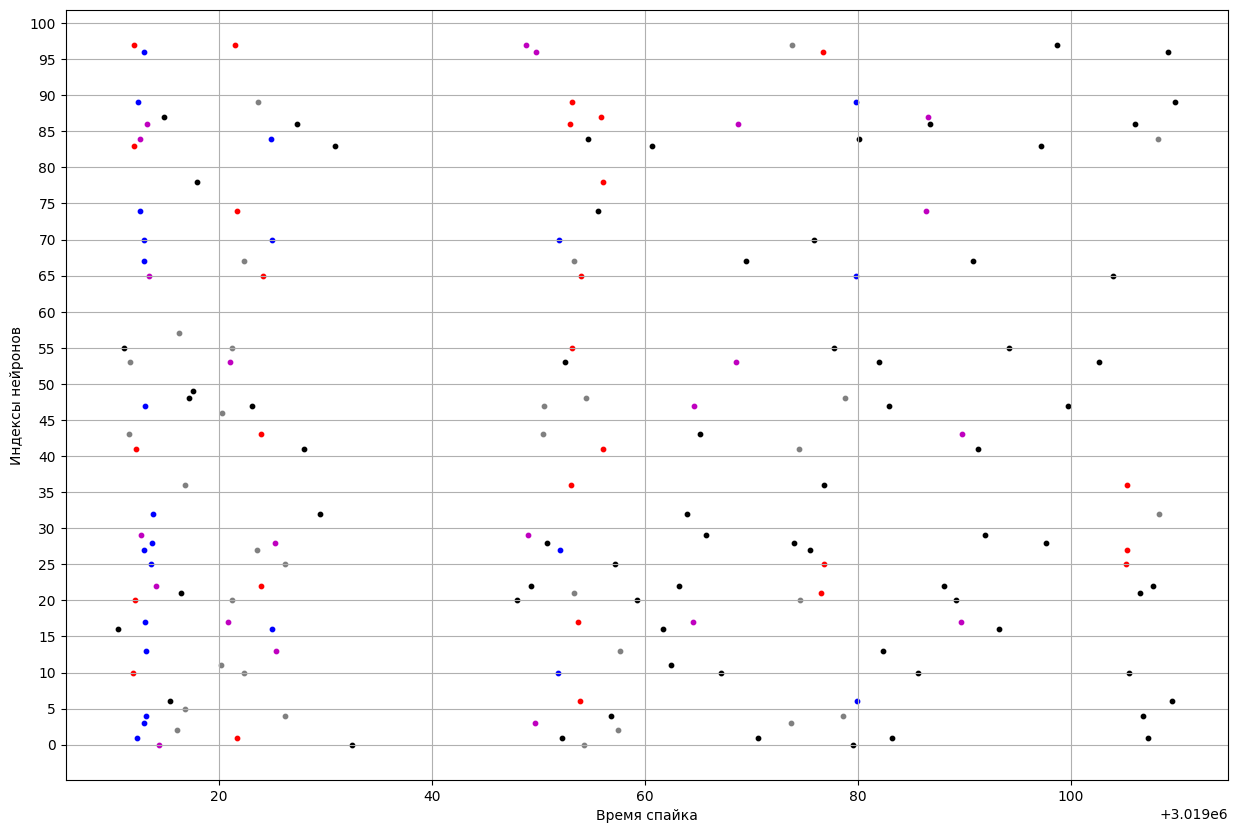

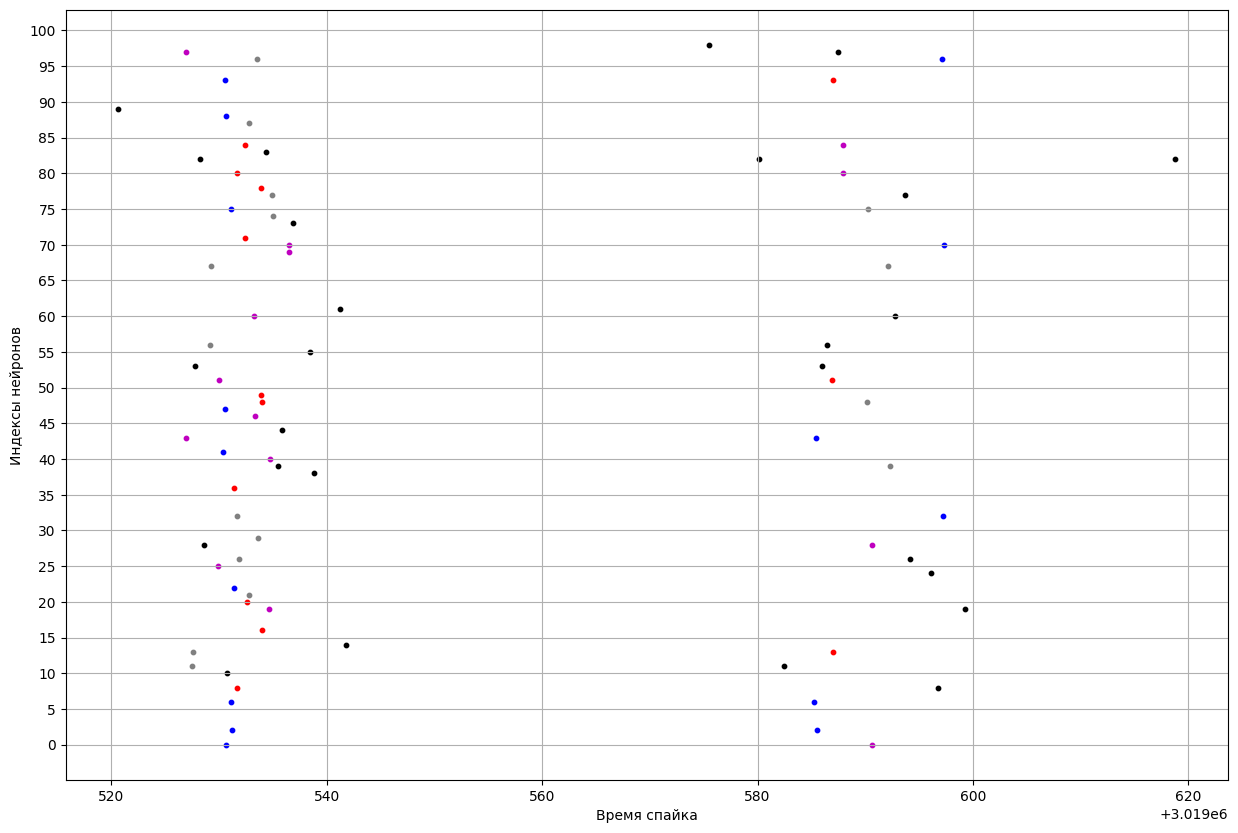

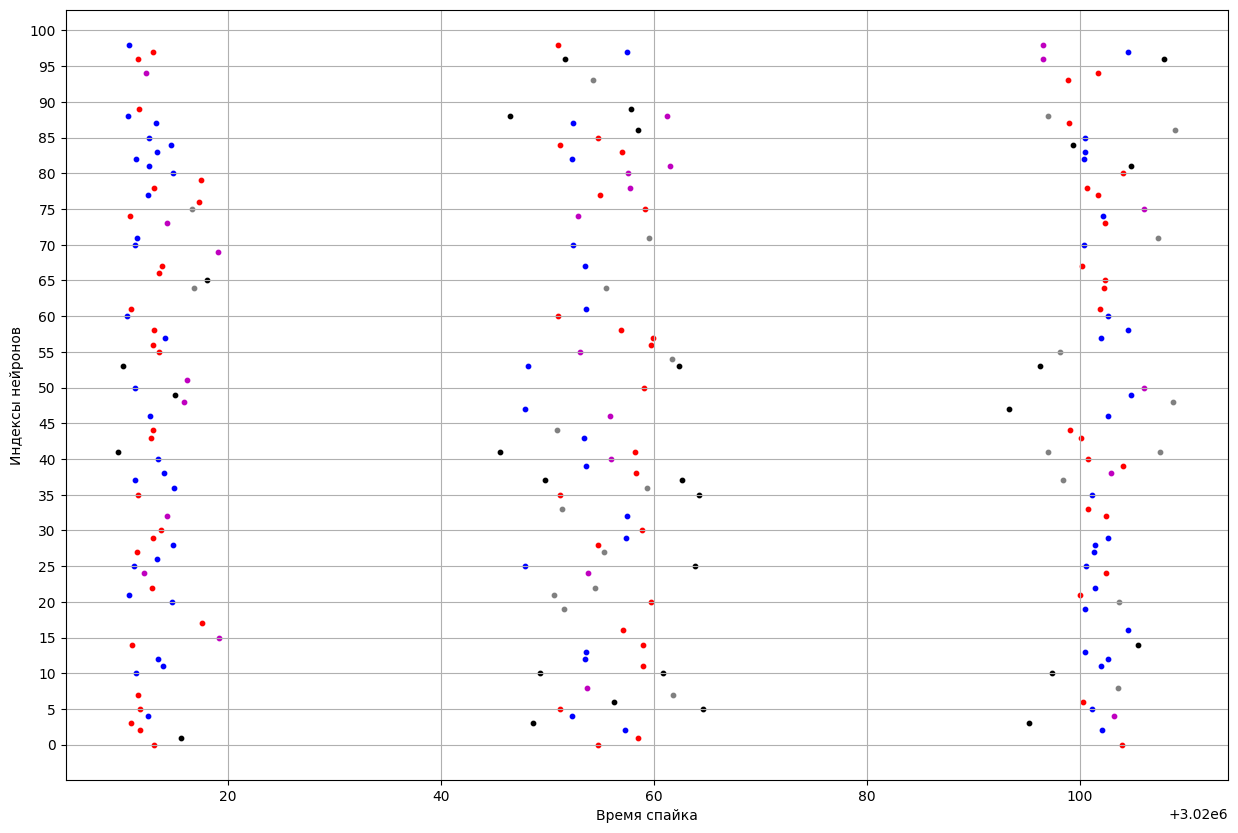

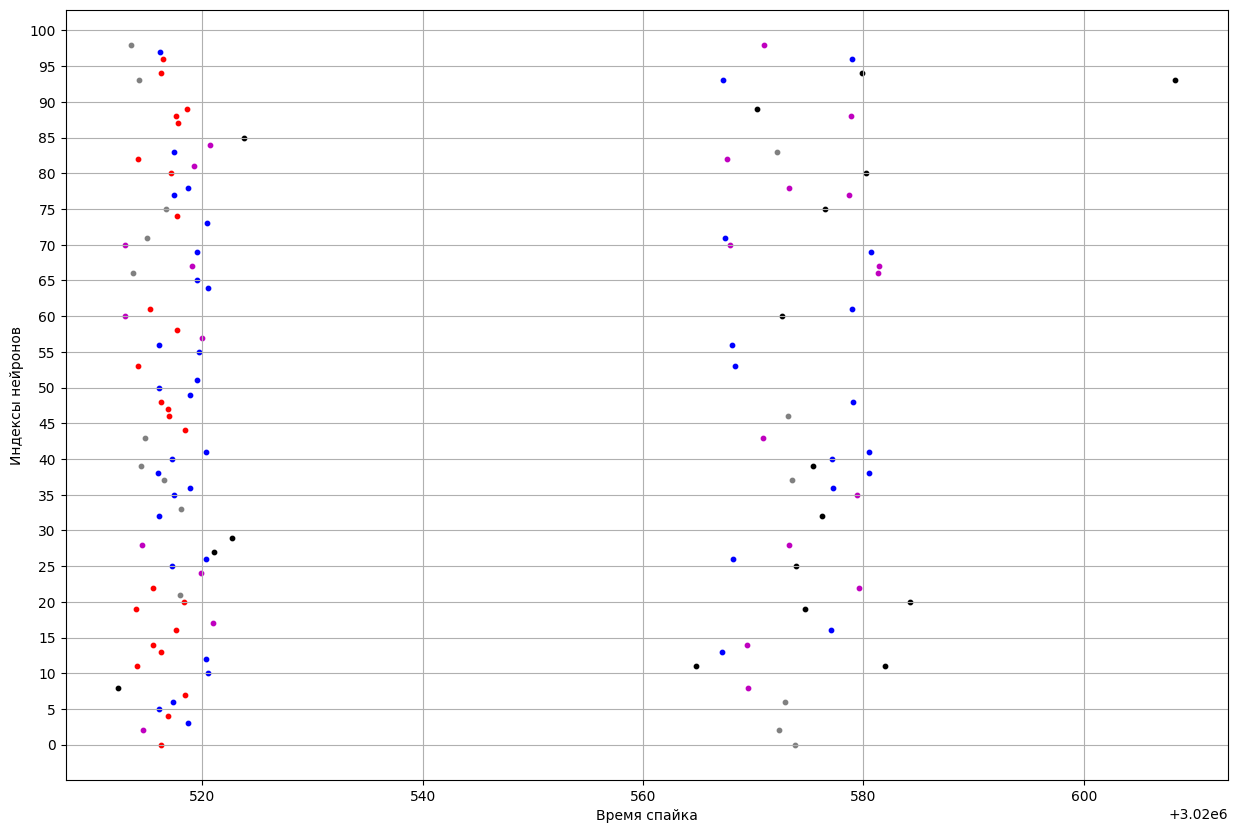

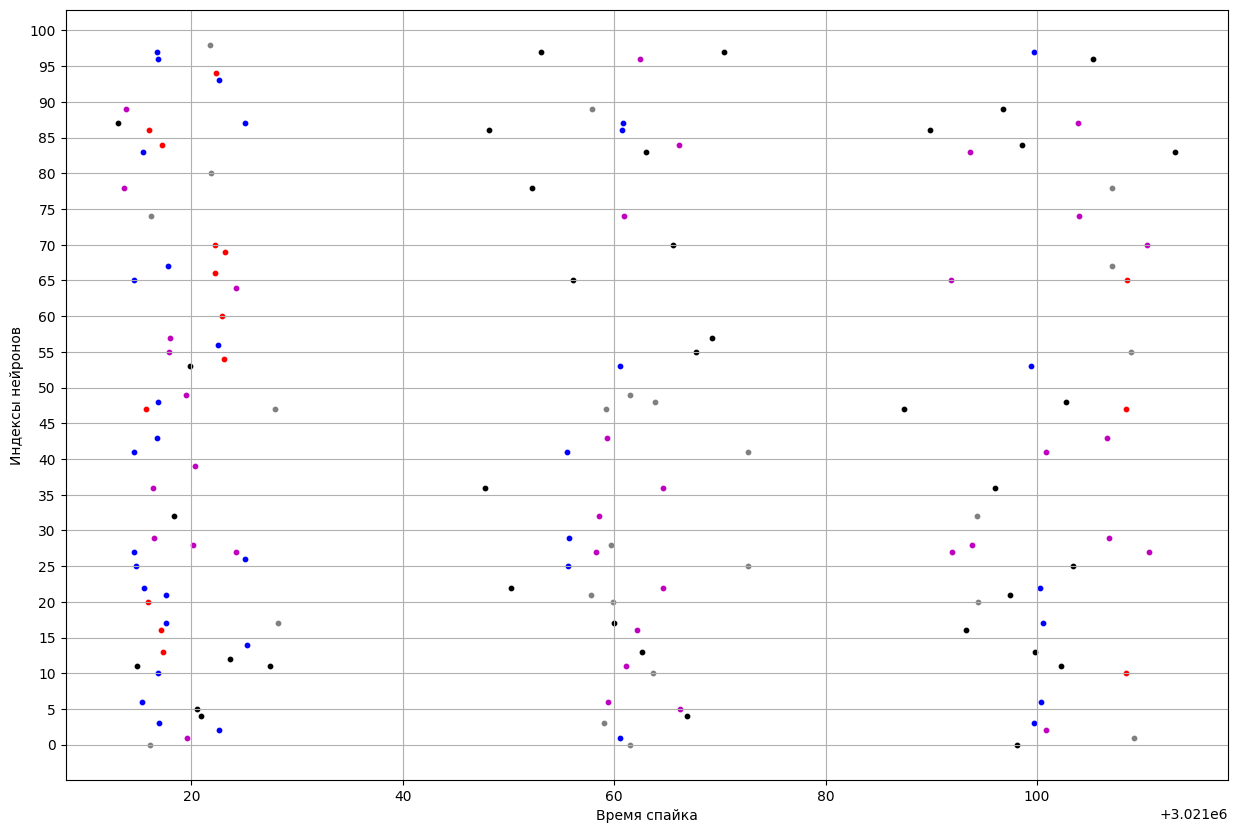

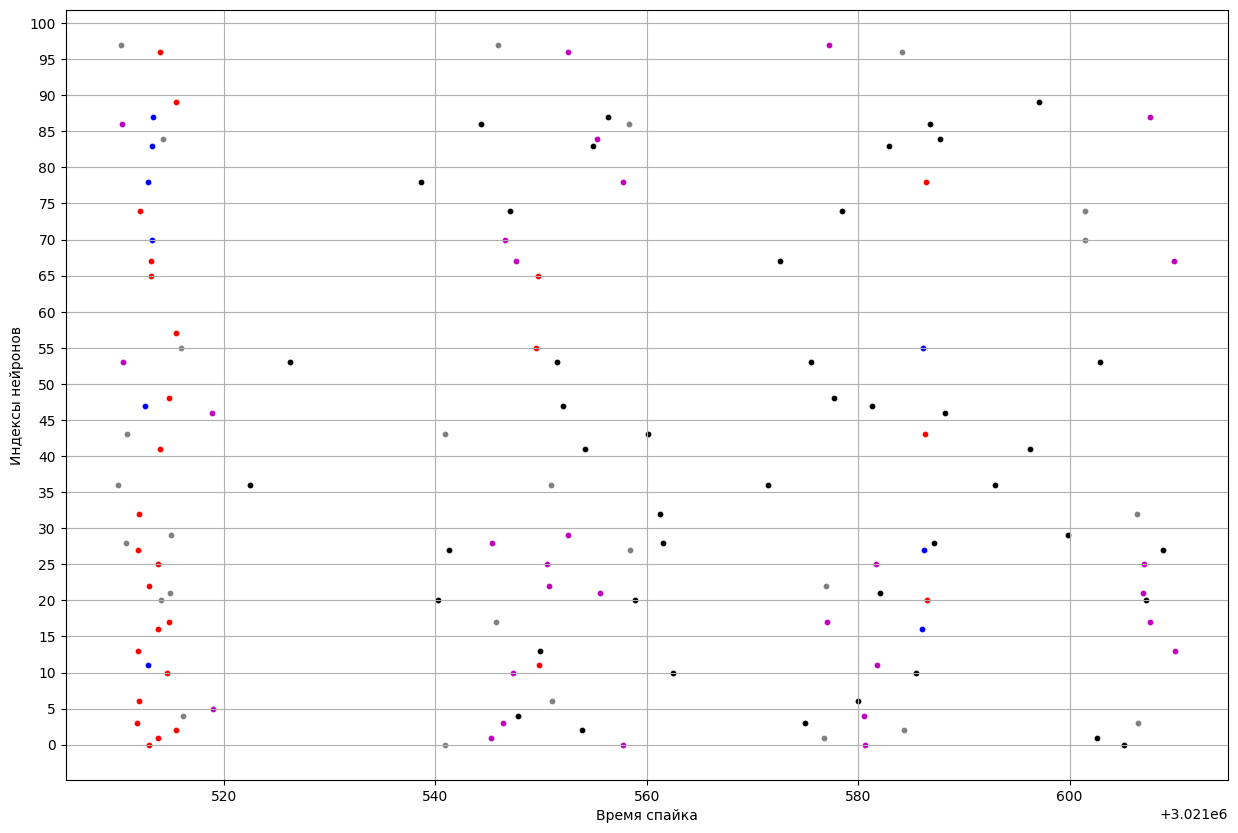

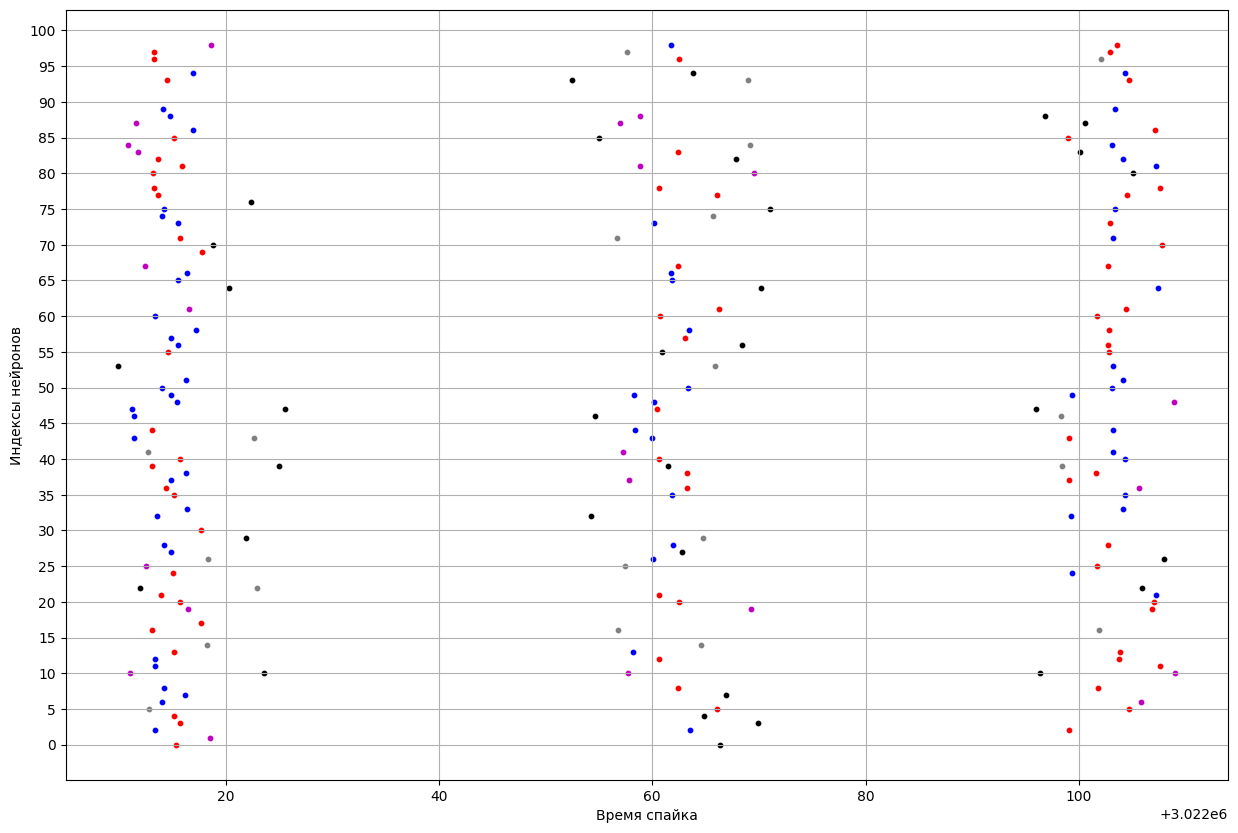

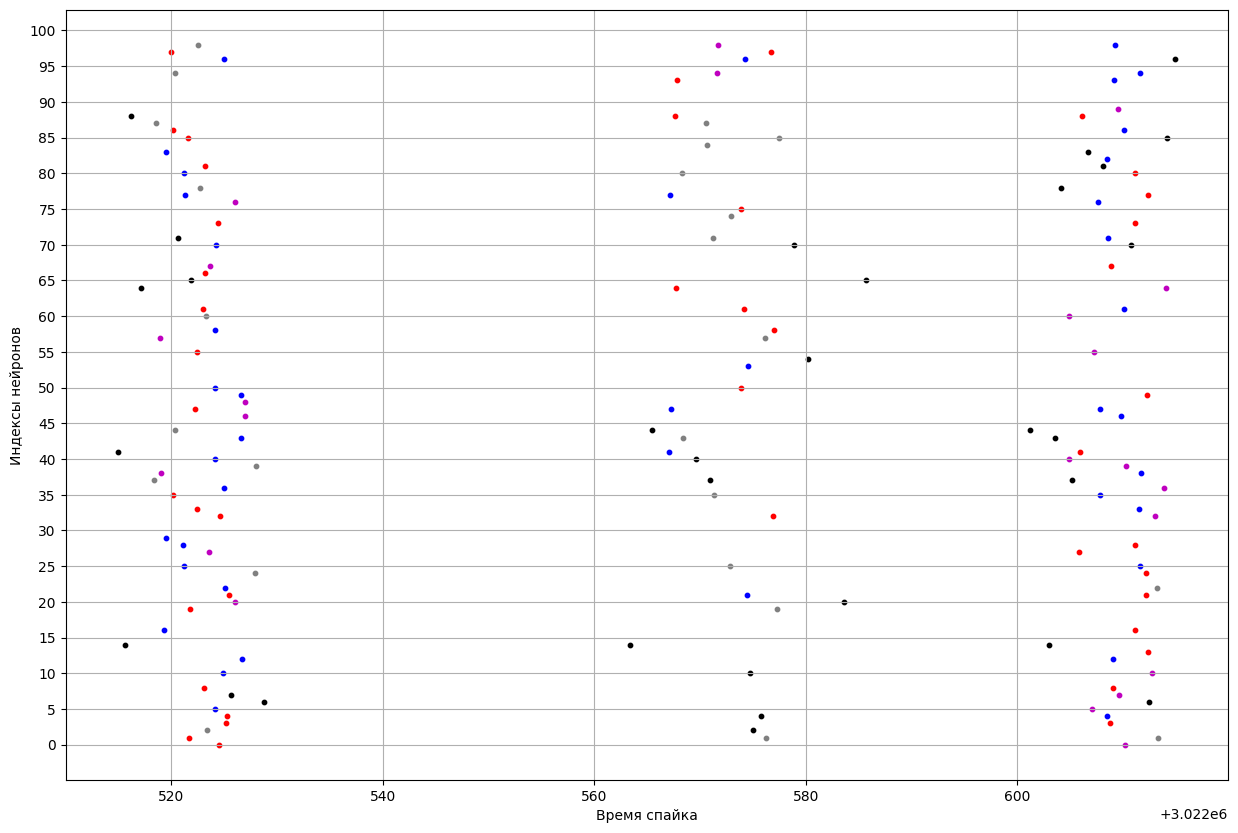

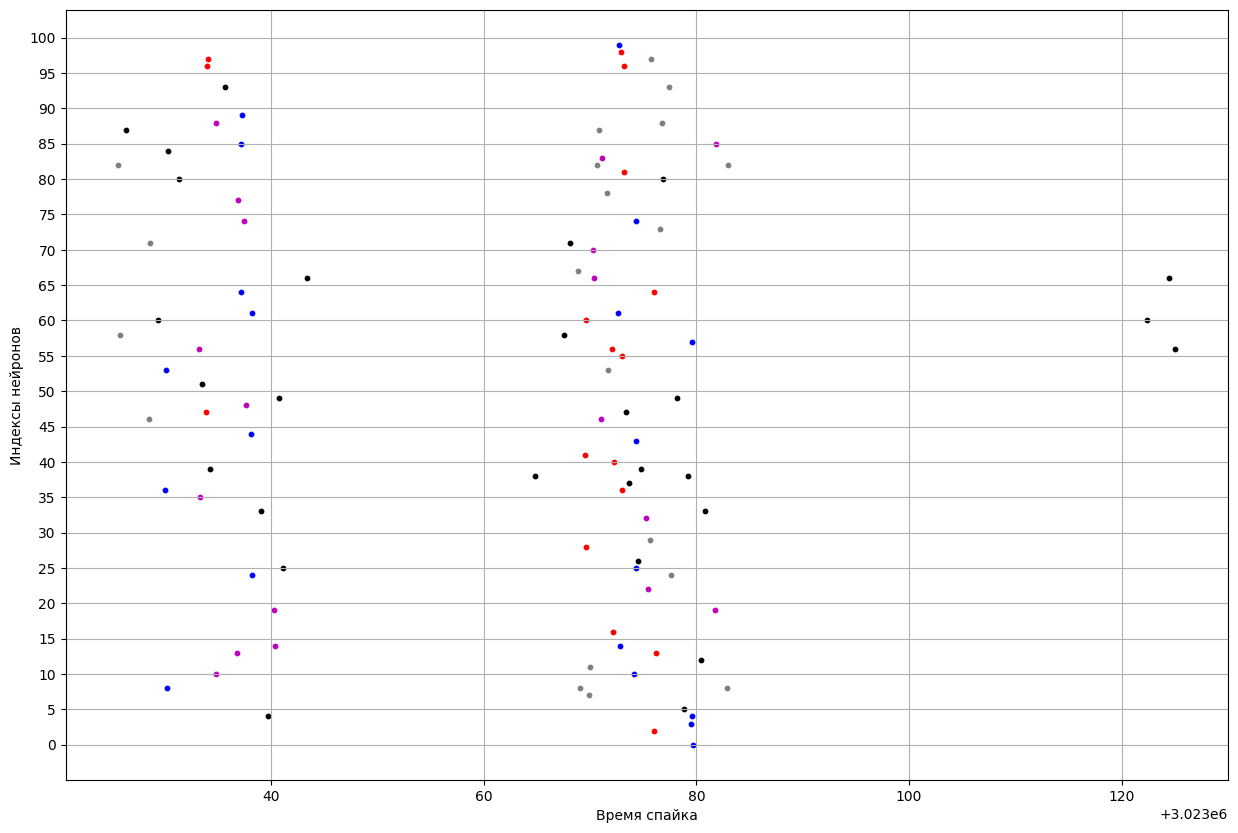

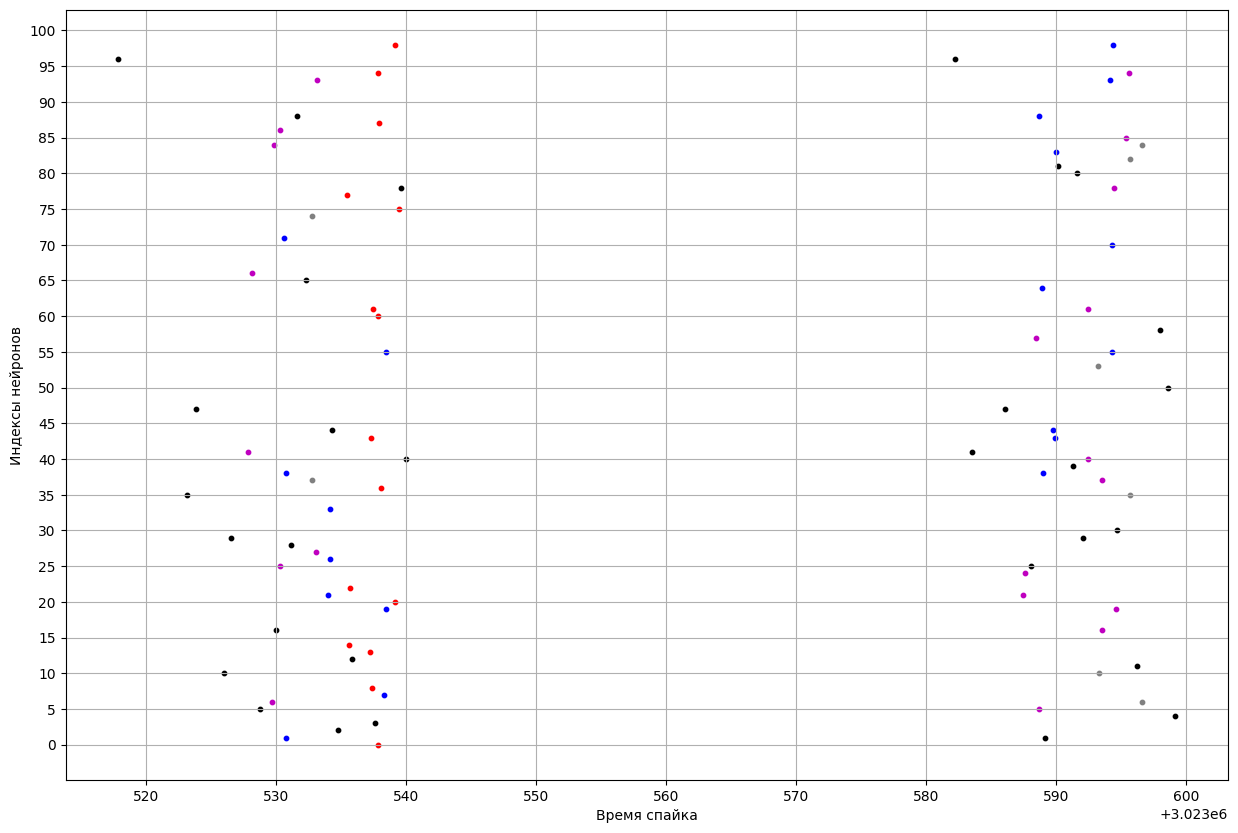

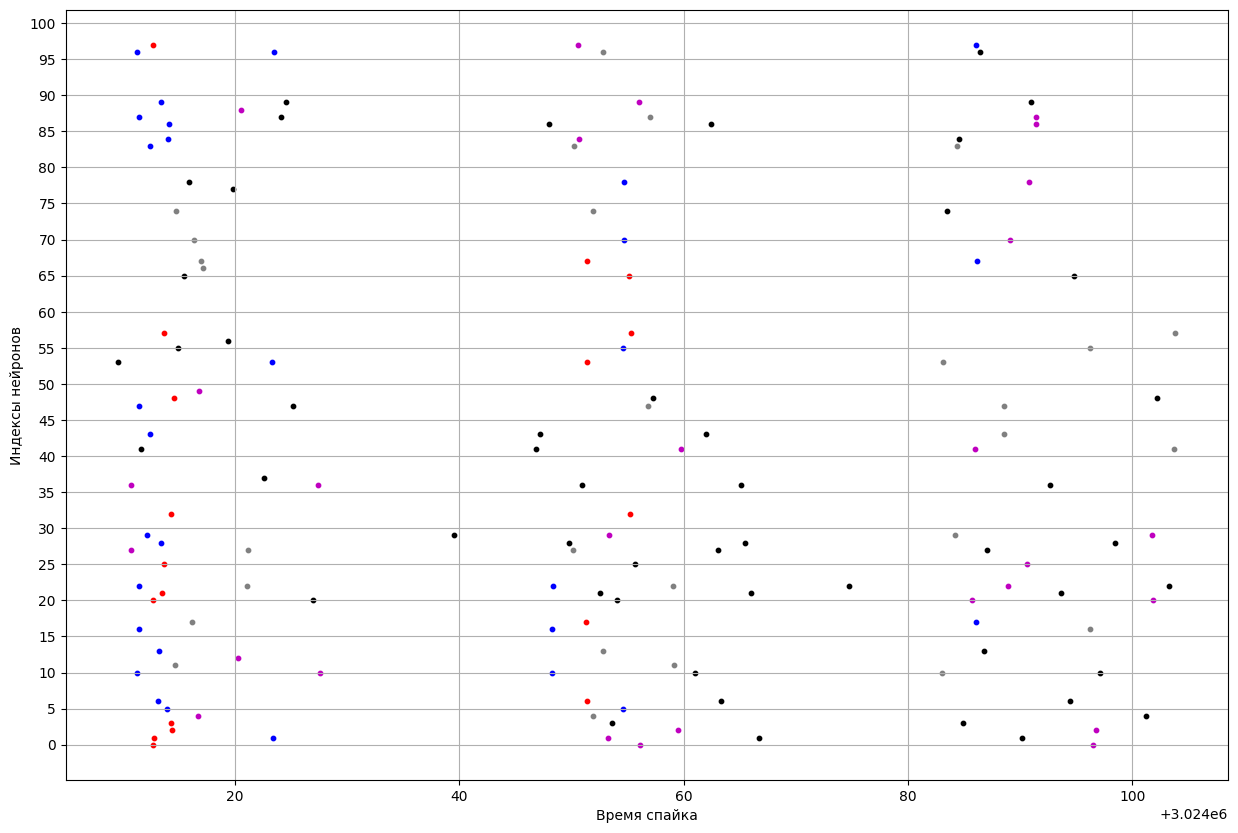

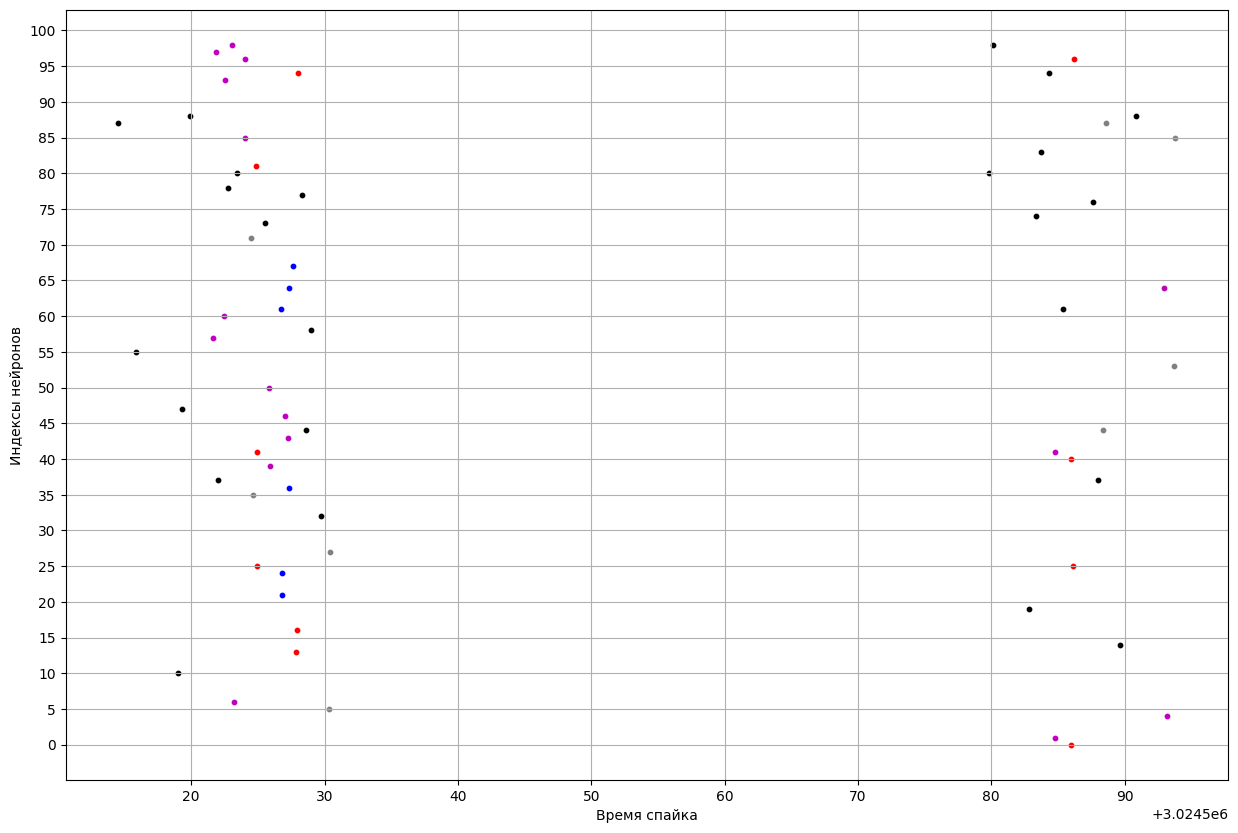

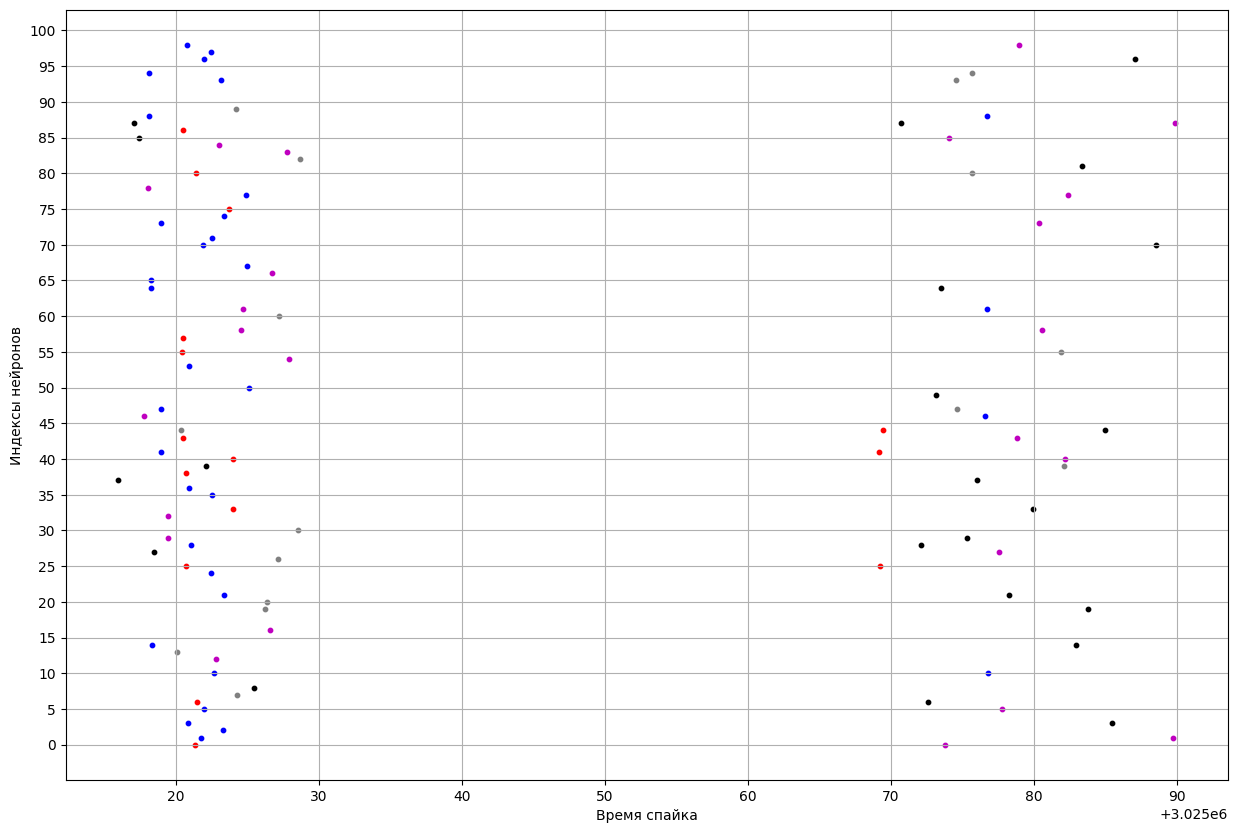

Error in callback <function flush_figures at 0x0000015CF3584A60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [31]:
def test1(train_items=5000, assign_items=1000, eval_items=100):
    '''
    Feed train set to SNN with STDP
    Freeze STDP
    Feed train set to SNN again and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    model = Model()
    model.train(X_train[:train_items], y_train[:train_items], epoch=1)
    model.net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')
    
    f_train = model.evaluate(X_train[:assign_items], y_train[:assign_items], drow=False)
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print(clf.score(f_train, y_train[:assign_items]))

    f_test = model.evaluate(X_test[:eval_items], y_test[:eval_items], drow=True)
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test1()